### Deep Q-Network
Based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


Setup the notebook

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_in_jupyter(frames):
    """
    Thanks to http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html
    Install JSAnimation: pip3 install git+https://github.com/jakevdp/JSAnimation.git --user
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    

Define the Q-network. Note we do not use any activation function for the output layer, since we want to estimate the Q-values

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(4, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



Define a class for storing the previous experiences (replay memory). We define a named tuple for storing the state, the action performed, the next state along with the reward obtained during the transition.

In [3]:
from collections import namedtuple

# Things that we need to store to the memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory:

    def __init__(self, capacity, batch_size=128):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.batch_size = batch_size

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self):
        batch = random.sample(self.memory, self.batch_size)
        # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for detailed explanation).
        batch = Transition(*zip(*batch))
        return batch

    def __len__(self):
        return len(self.memory)

Define a function for selecting the next action according to the maximum Q-value. Note that we want to explore different actions during the training process. The exploration should be decreases during the training.

In [4]:
def select_action(state, q_net, steps_done=0, exploration=None, n_actions=2):
    state = torch.from_numpy(state).type(torch.FloatTensor).view(1, -1)
    
    if exploration is None:
        # Select an action without exploration (for testing)
        with torch.no_grad():
            return q_net(state).max(1)[1].view(1, 1)
    else:
        # Select an action using exploration (for training)
        sample = random.random()
        
        # Linear exploration policy implemented
        a, b =-((exploration['start'] - exploration['end']) / exploration['episodes']),  exploration['start']
        eps_threshold = a * steps_done + b
        eps_threshold = eps_threshold if eps_threshold > exploration['end'] else exploration['end']
        
        # Select whether to perform a random action or to use the network to select the action
        if sample > eps_threshold:
            with torch.no_grad():
                return q_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)


Define a function for updating the network according the sampled transitions from the replay memory

In [5]:
def optimize_model(optimizer, q_net, target_net, memory, gamma=0.99, batch_size=128):
    
    # Wait until memory has enough samples
    if len(memory) < batch_size:
        return

    # Get some samples
    batch = memory.sample()
    state_batch = torch.stack(batch.state)
    action_batch = torch.stack(batch.action)
    action_batch = action_batch.resize(action_batch.size(0), 1)
    reward_batch = torch.stack(batch.reward).squeeze()

    # Compute Q(s_t, a)
    state_action_values = q_net(state_batch)
    state_action_values = state_action_values.gather(1, action_batch).squeeze()

    # Compute V(s_{t+1}) for all next states.
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,  batch.next_state)), dtype=torch.uint8)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])
    
    next_state_values = torch.zeros(batch_size)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch + gamma*next_state_values 

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    

Define the main training loop

In [6]:
def train_agent(q_net, target_net, env, num_episodes=1000, target_network_update=100,
                exploration={'start': 0.9, 'end': 0.05, 'episodes': 1000},
                gamma=0.99, max_steps=500, batch_size=128, lr=0.0001):
    
    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    memory = ReplayMemory(10000, batch_size=batch_size)

    # Copy the main net to the target_net
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    # Keep some stats
    steps_done = 0
    running_reward = 0
    running_q = 0
    reward_history = []
    q_history = []
    
    for episode in range(num_episodes):
        state = env.reset()

        for t in range(max_steps):
            
            # Select and perform an action
            action = select_action(state, q_net, exploration=exploration, steps_done=episode)
            next_state, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward])

            # Store the transition in memory
            if done:
                memory.push(torch.tensor(np.float32(state)), action, None, reward)
            else:
                memory.push(torch.tensor(np.float32(state)), action, torch.tensor(np.float32(next_state)), reward)

            running_q = running_q * 0.95 + 0.05 * torch.max(q_net(torch.tensor(np.float32(state)))).item()
            state = next_state

            # Perform one step of the optimization 
            optimize_model(optimizer, q_net, target_net, memory, gamma=gamma, batch_size=batch_size)

            steps_done += 1
            if done:
                break

        running_reward = running_reward * 0.95 + t * 0.05
        q_history.append(running_q)
        reward_history.append(running_reward)

        # Update the target network
        if episode % target_network_update == 0:
            target_net.load_state_dict(q_net.state_dict())
        
        # Print some statistics
        if episode % 20 == 0:   
            print("episode = ", episode, "avg reward = ", running_reward, "avg q = ", running_q)
    return reward_history, q_history


Also, write a function for testing the network (as before):

In [7]:
def run_one_episode(net, env):
    # Run an episode
    
    state = env.reset()
    frames = []
    total_reward = 0

    for cur_step in range(500):
        frames.append(env.render(mode='rgb_array'))
        action = select_action(state, q_net, exploration=None,).item()
        state, reward, done, _ = env.step(action)
        total_reward +=reward
       
        if done:
            break

    display_in_jupyter(frames)
    print("Total reward: ", total_reward)

                

In [8]:
import gym
q_net = DQN()
target_net = DQN()
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.



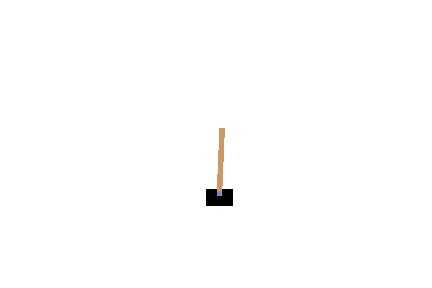
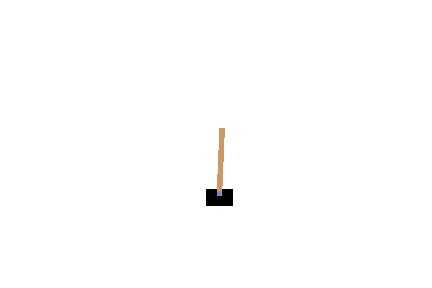
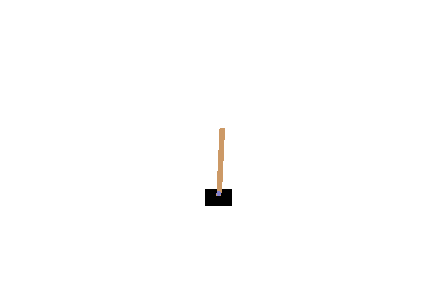
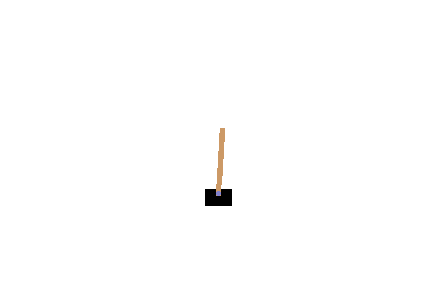
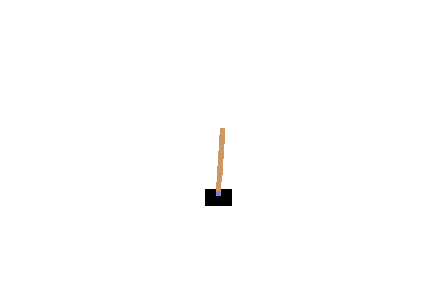
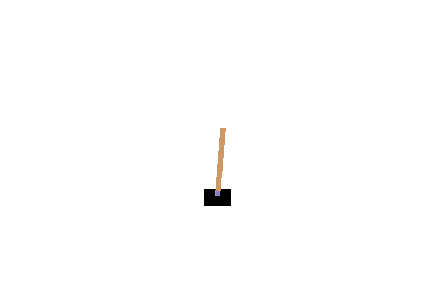
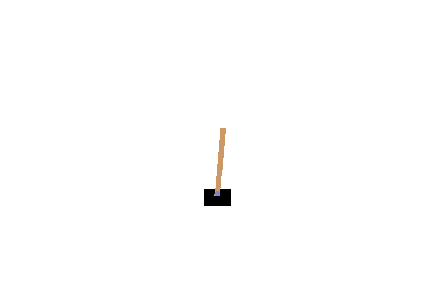
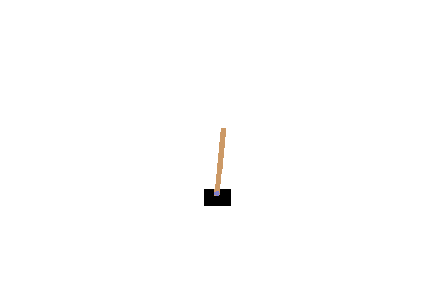
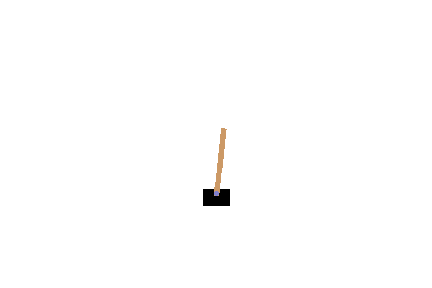
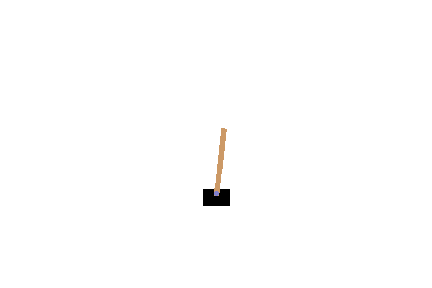
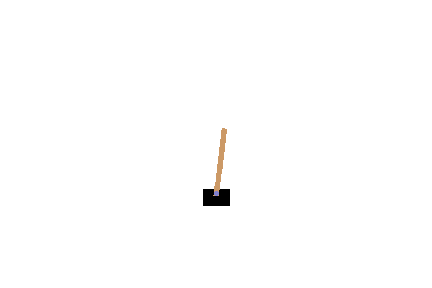
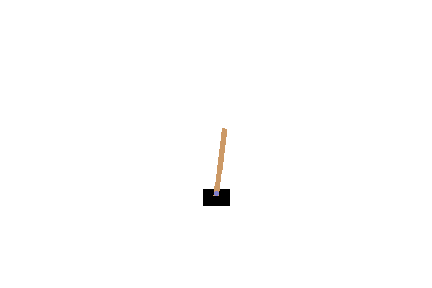
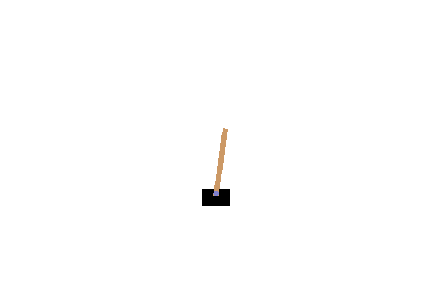
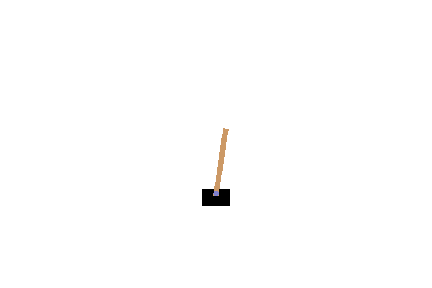
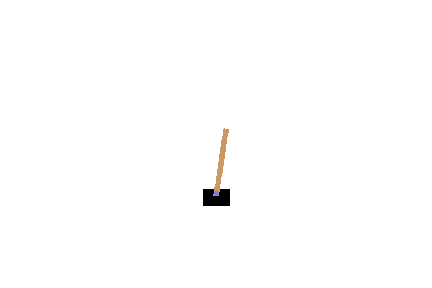
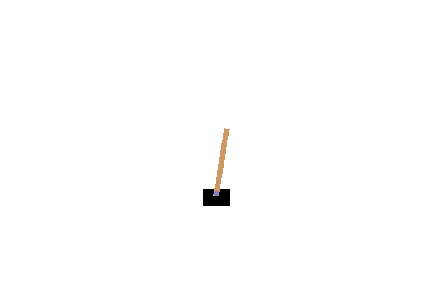
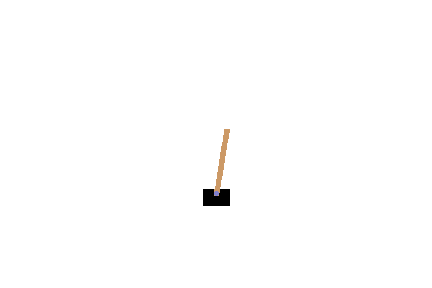
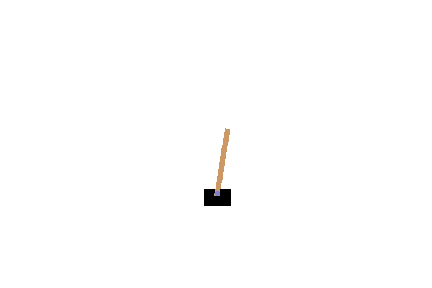
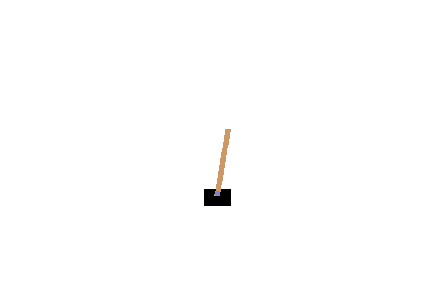
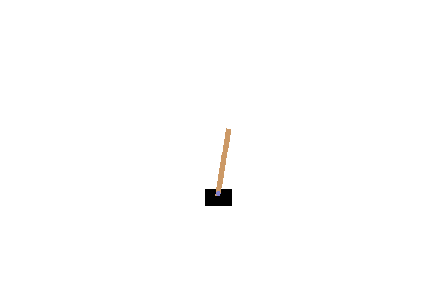
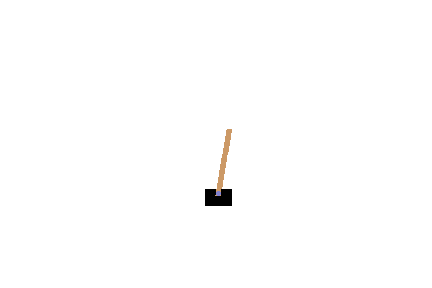
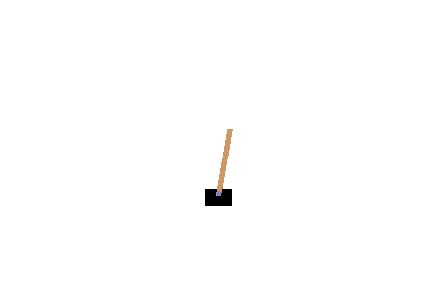
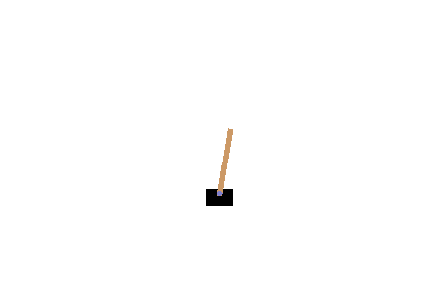
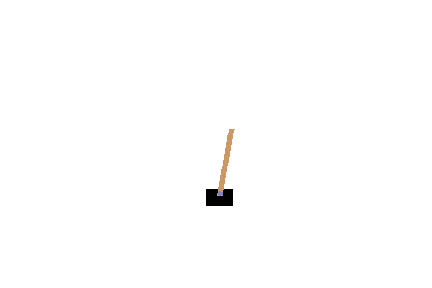
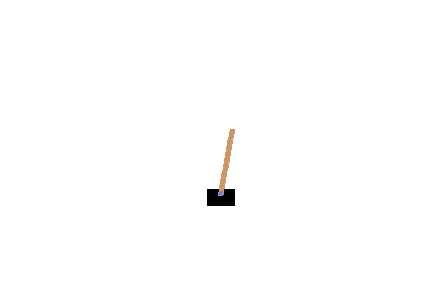
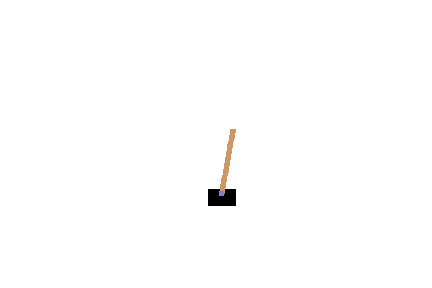
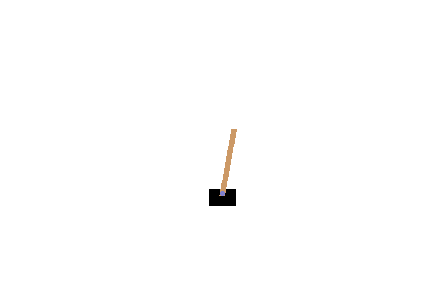
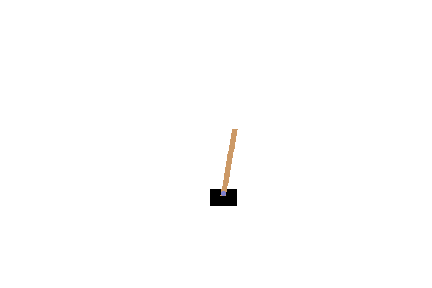
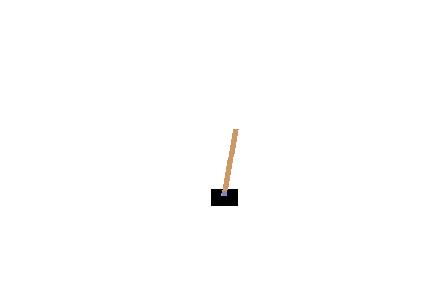
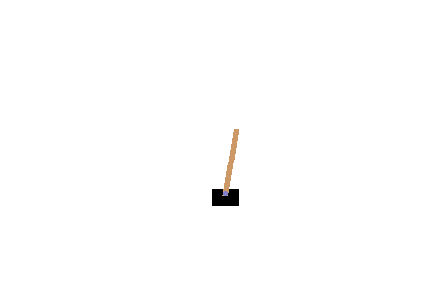
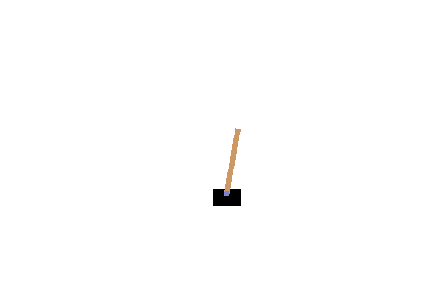
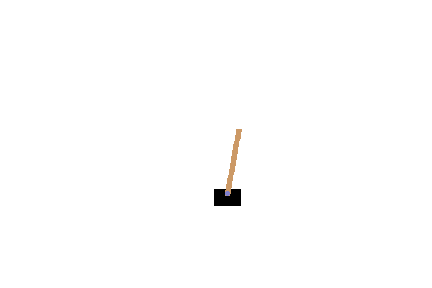
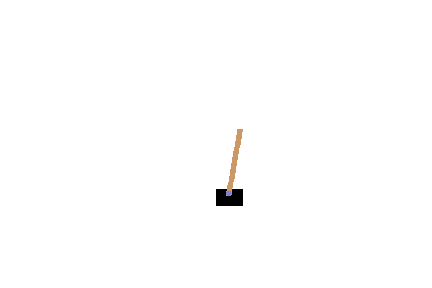
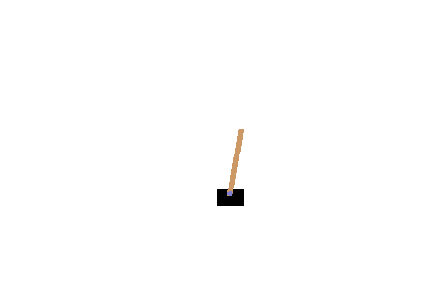
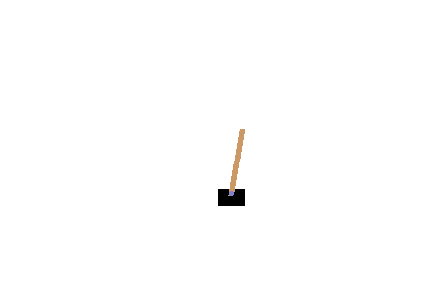
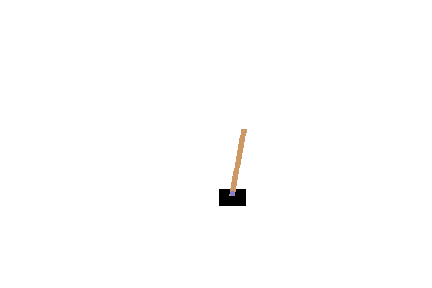
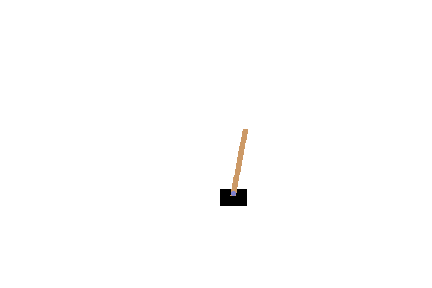
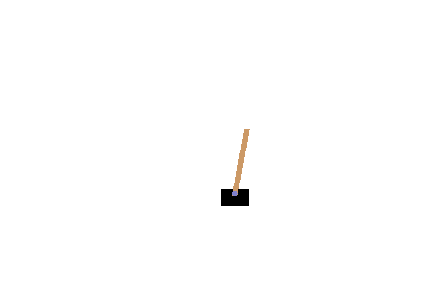
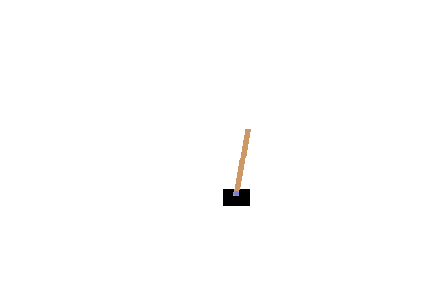
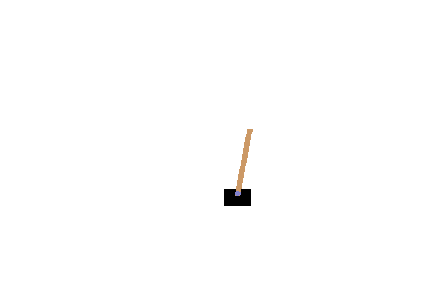
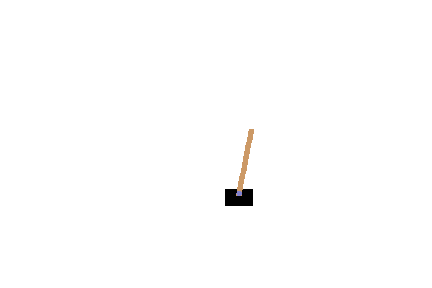
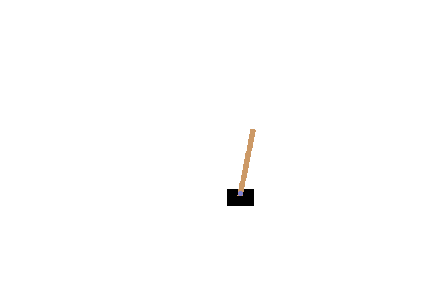
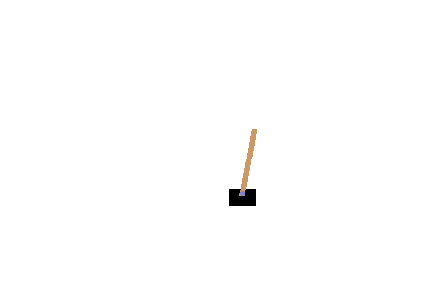
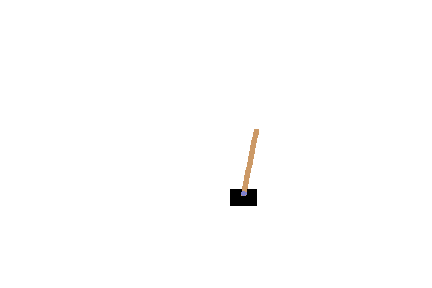
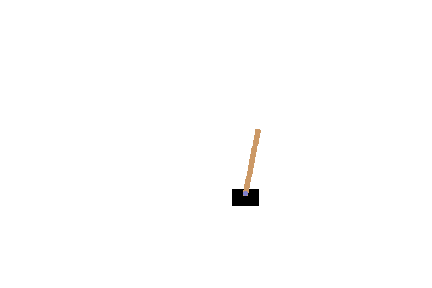
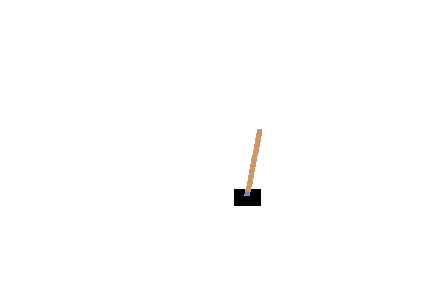
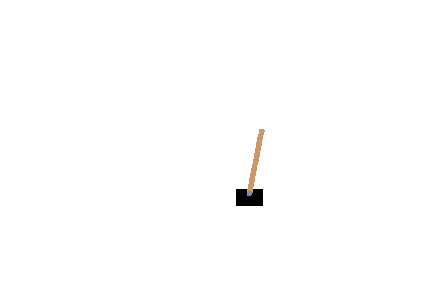
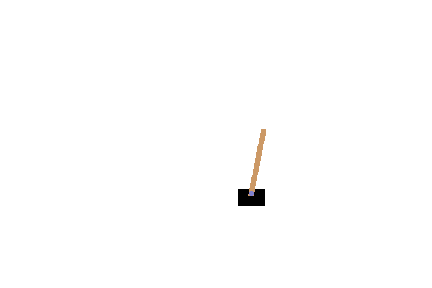
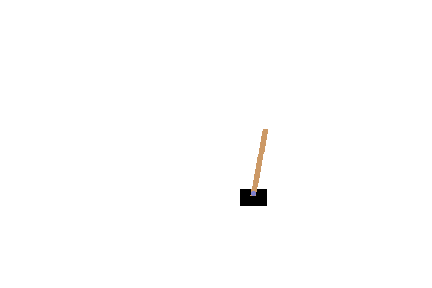
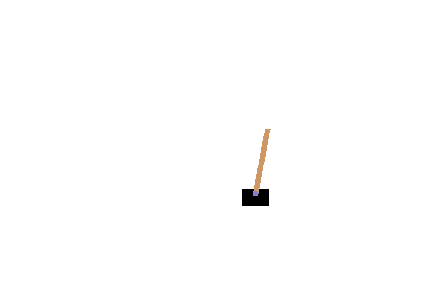
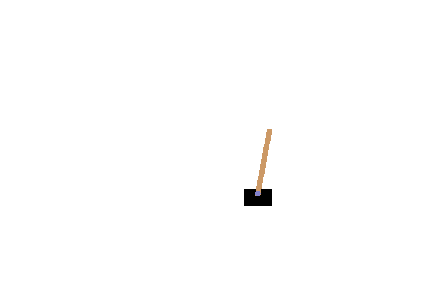
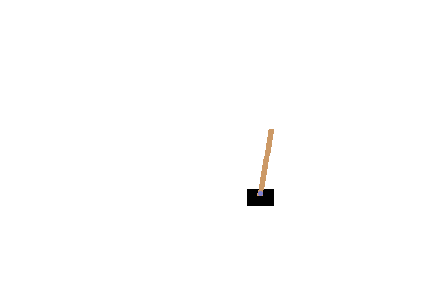
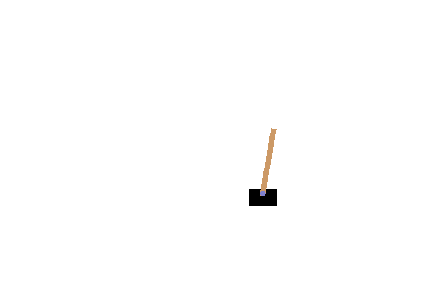
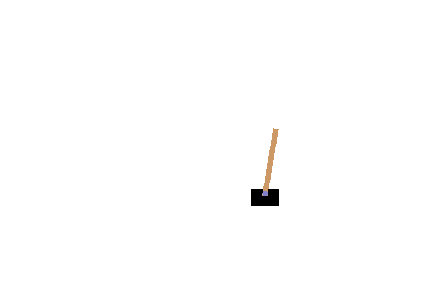
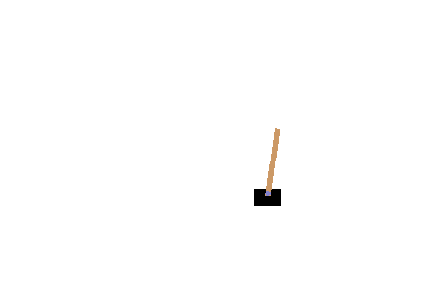
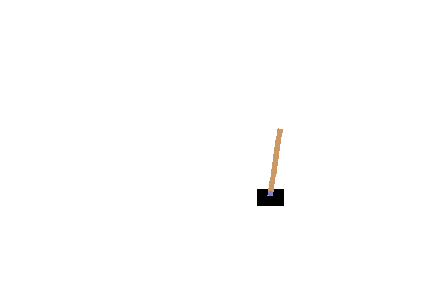
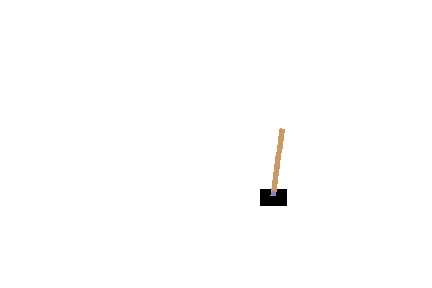
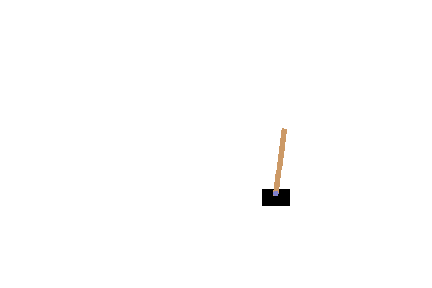
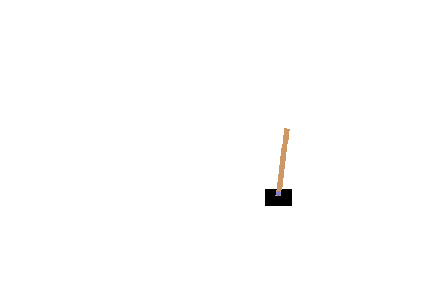
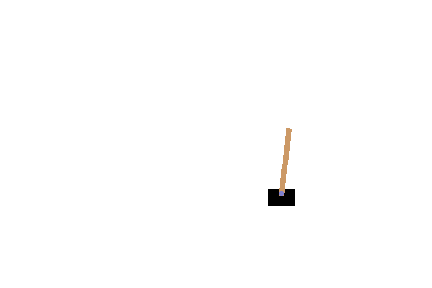
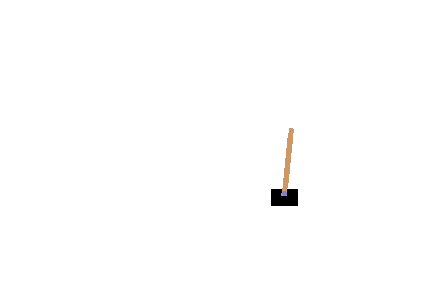
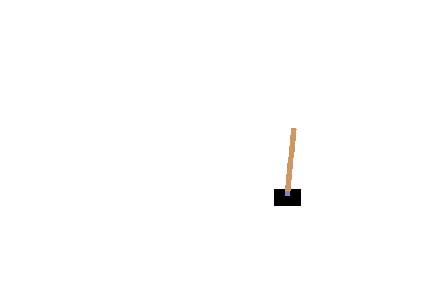
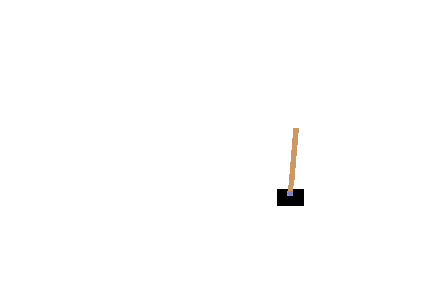
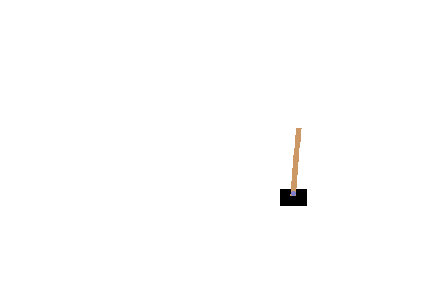
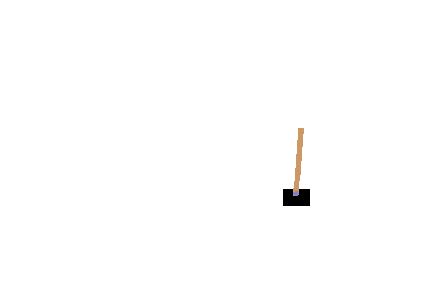
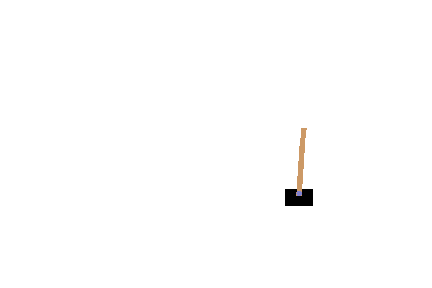
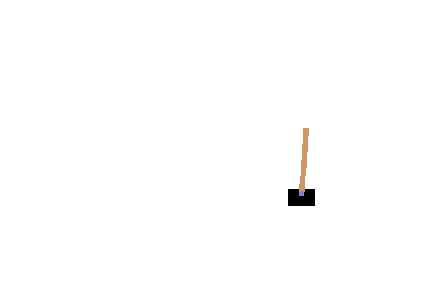
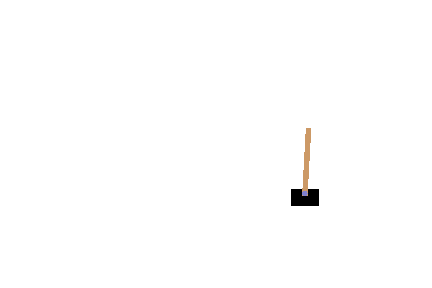
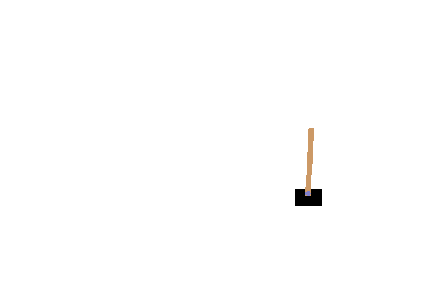
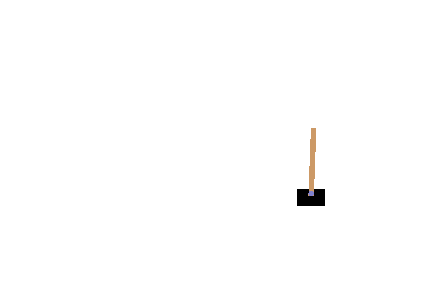
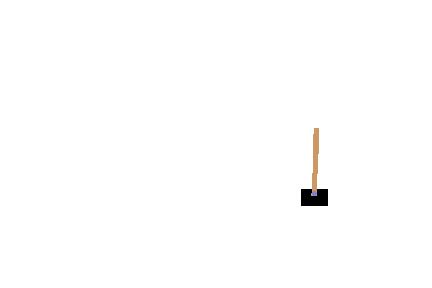
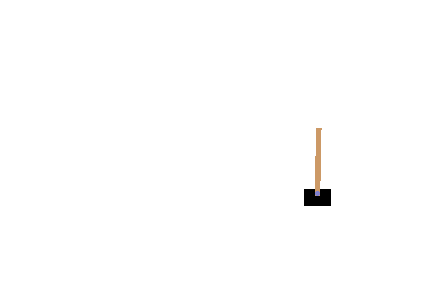
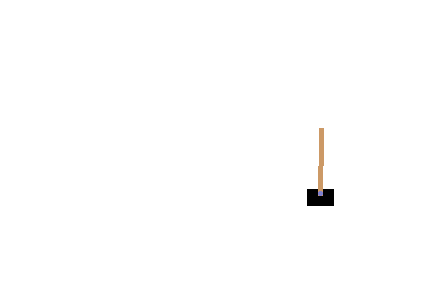
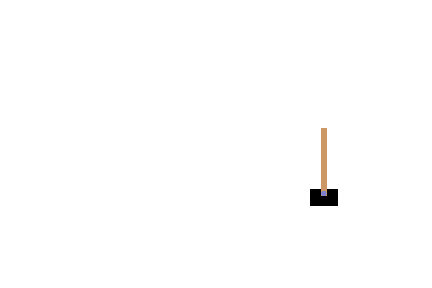
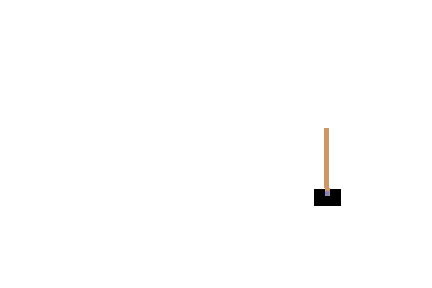
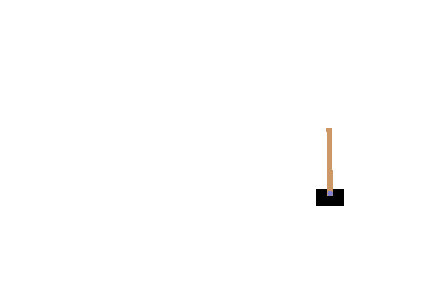
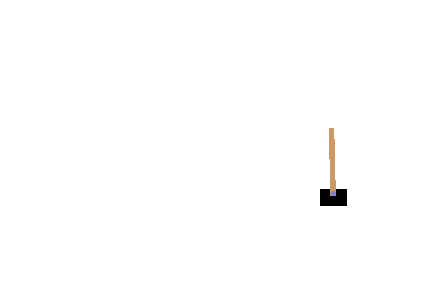
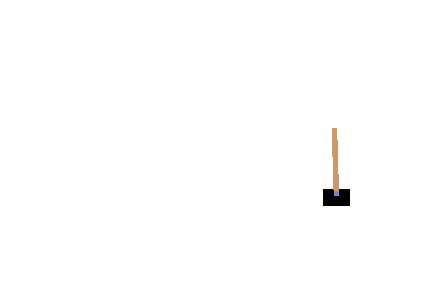
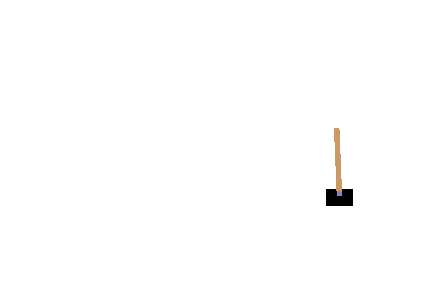
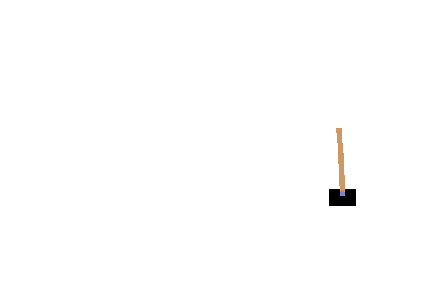
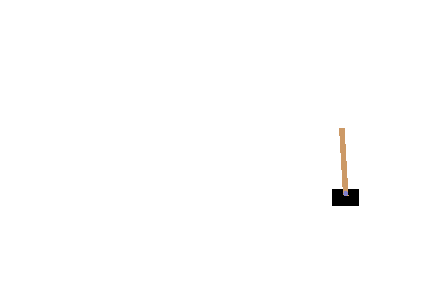
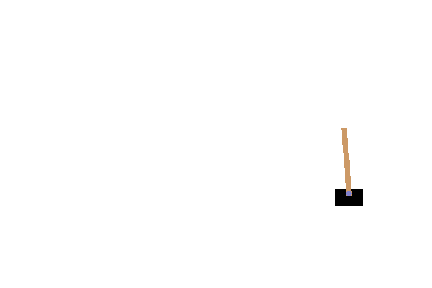
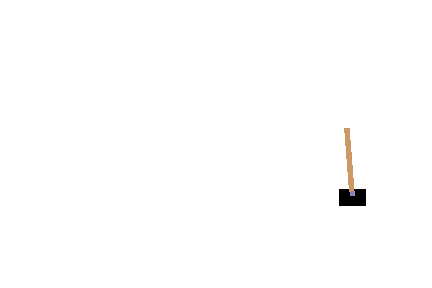
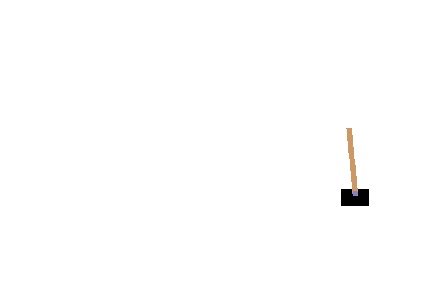
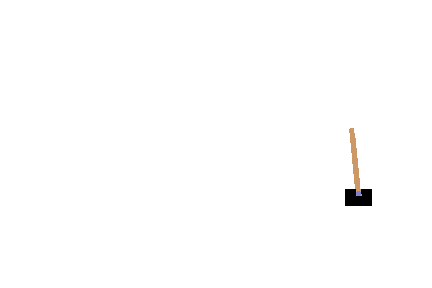
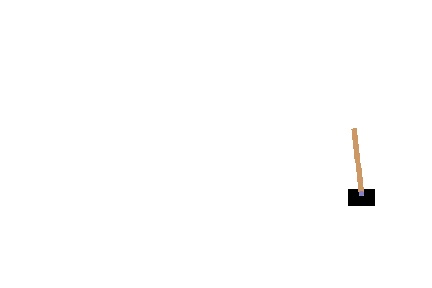
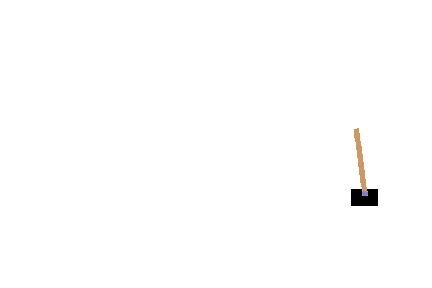
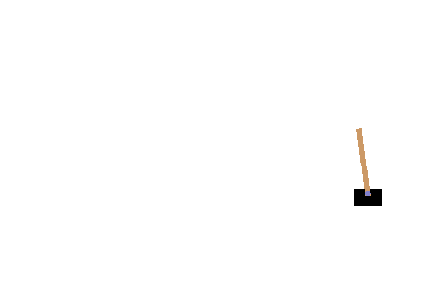
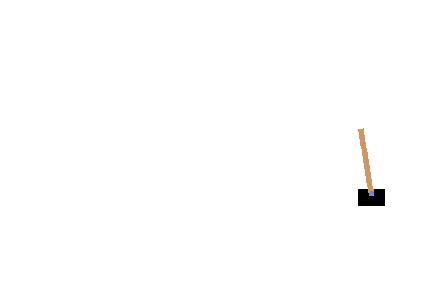
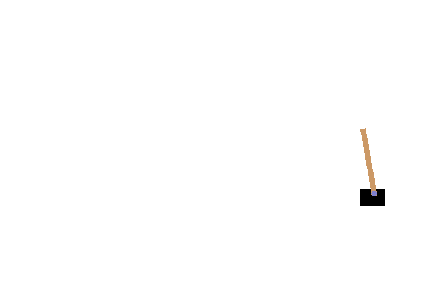
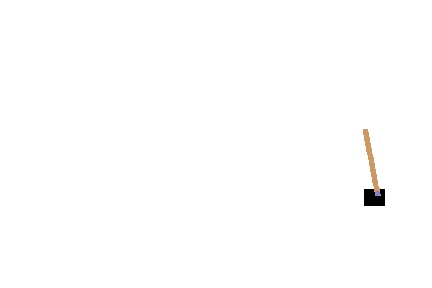
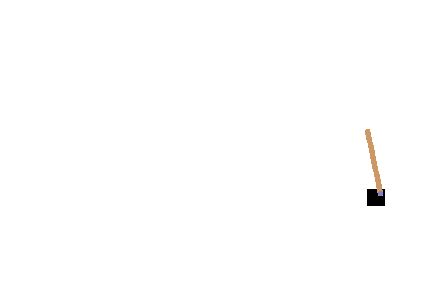

Total reward:  92.0


In [9]:
run_one_episode(q_net, env)

Train the agent!

In [10]:
reward_history, q_history = train_agent(q_net, target_net, env)

episode =  0 avg reward =  1.0 avg q =  -0.03291154713751549


/home/nick/.local/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


episode =  20 avg reward =  15.265191210993233 avg q =  1.0152883477040968
episode =  40 avg reward =  19.97249547723736 avg q =  0.992646499935726
episode =  60 avg reward =  21.989000778238523 avg q =  0.9881939113564774
episode =  80 avg reward =  19.282385823457428 avg q =  0.9858218079430257
episode =  100 avg reward =  21.517447712926693 avg q =  0.9962656923544144
episode =  120 avg reward =  18.90363888244706 avg q =  1.937736175055618
episode =  140 avg reward =  16.635489973996997 avg q =  1.924398067884482
episode =  160 avg reward =  17.216425596316146 avg q =  1.9097948485656129
episode =  180 avg reward =  16.641259358707668 avg q =  1.927533827841267
episode =  200 avg reward =  14.283914912689989 avg q =  1.904762398460923
episode =  220 avg reward =  23.028894275165456 avg q =  2.81801649376445
episode =  240 avg reward =  32.3824647693594 avg q =  2.878235183160644
episode =  260 avg reward =  25.37635311631732 avg q =  2.7994441597589104
episode =  280 avg reward =  

Plot the rewards and the avg. max Q value during the training (useful for debugging)

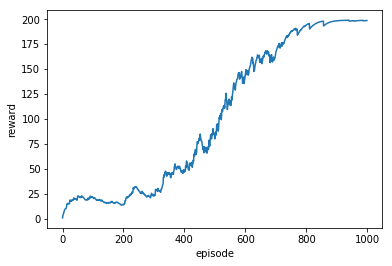

In [16]:
plt.plot(reward_history)
plt.ylabel('reward')
plt.xlabel('episode')
plt.show()


Evaluate the agent!


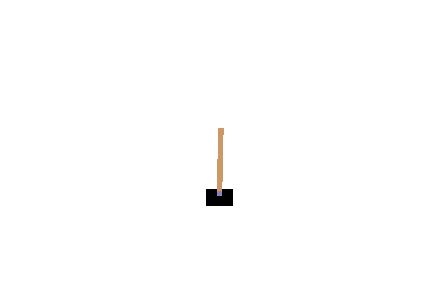
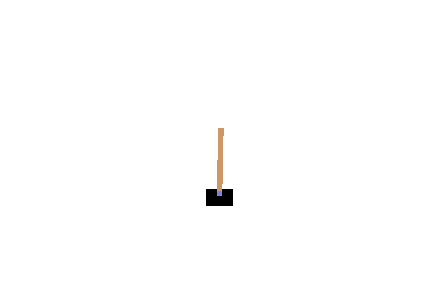
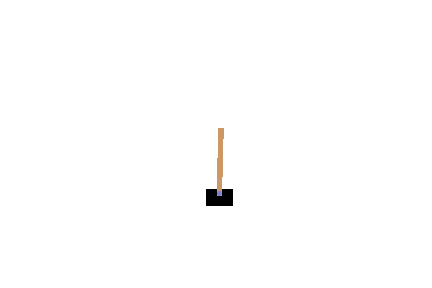
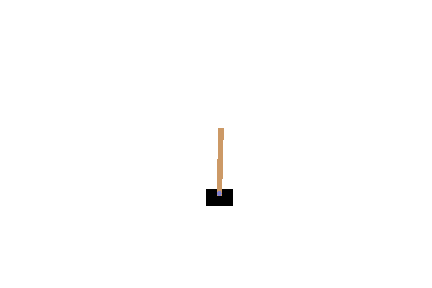
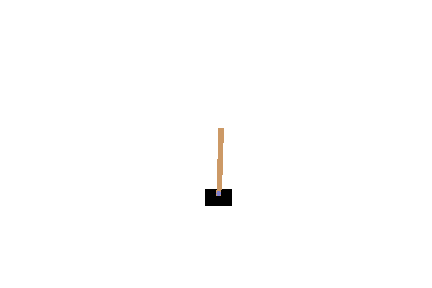
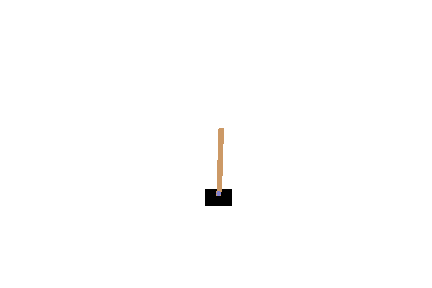
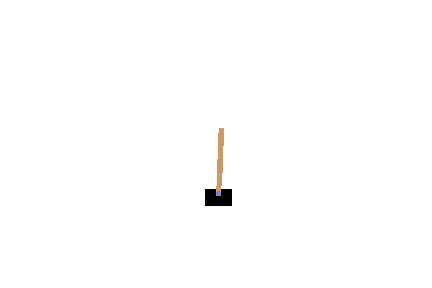
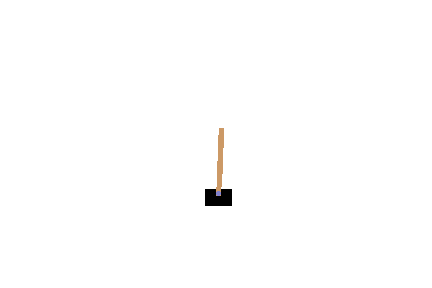
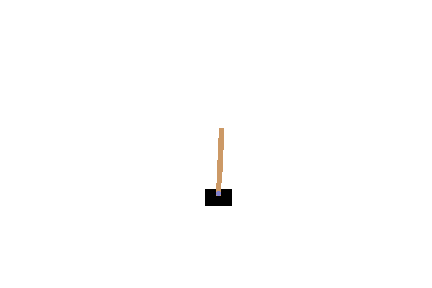
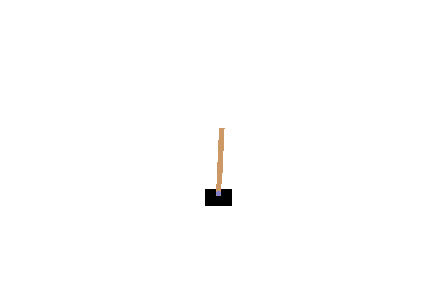
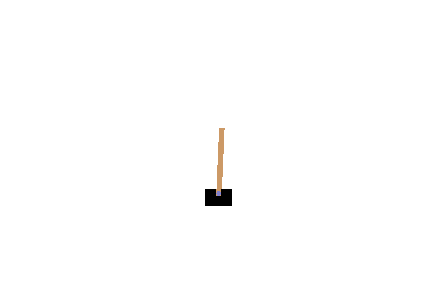
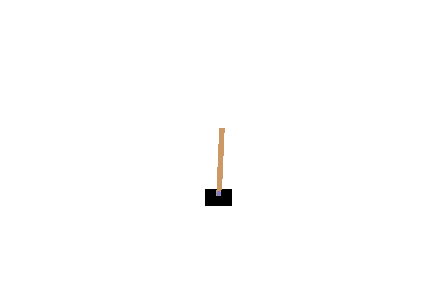
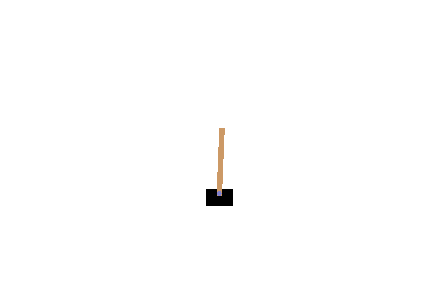
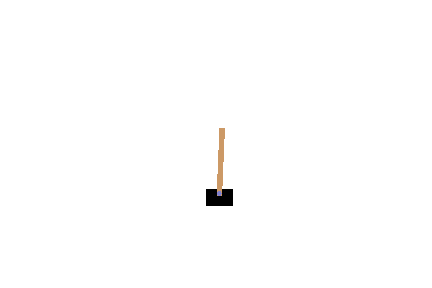
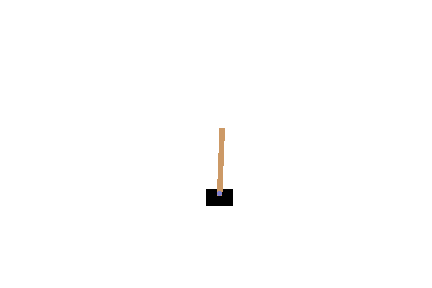
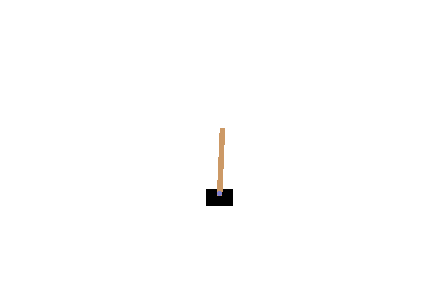
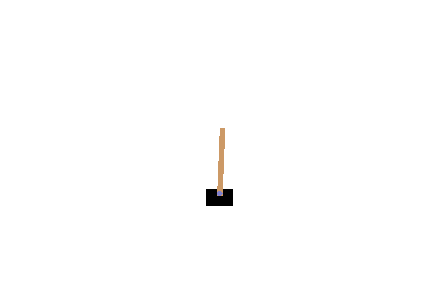
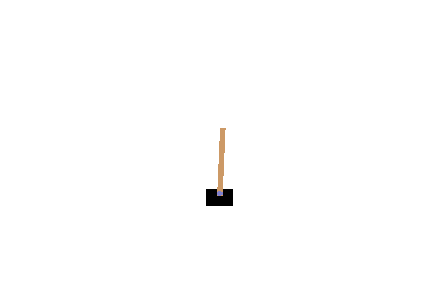
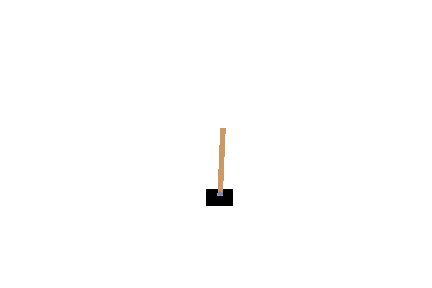
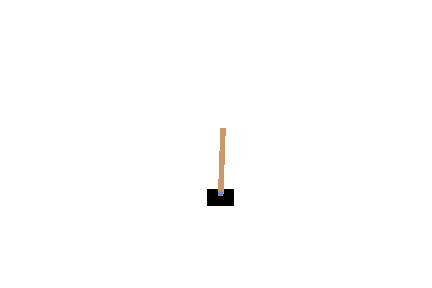
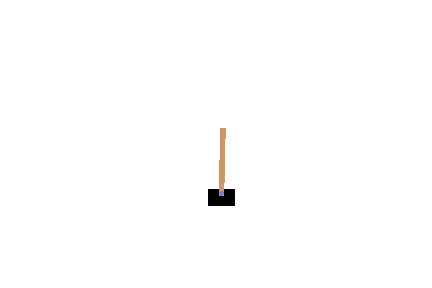
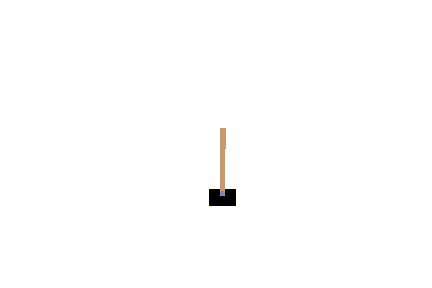
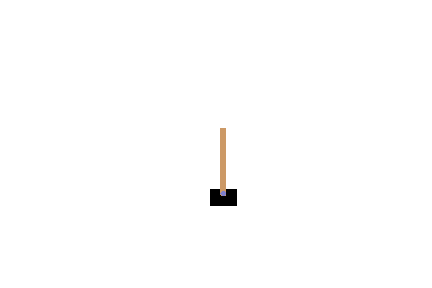
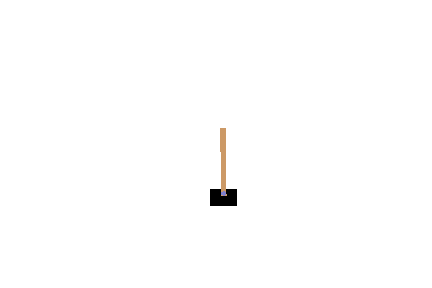
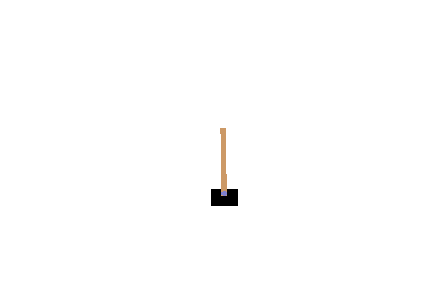
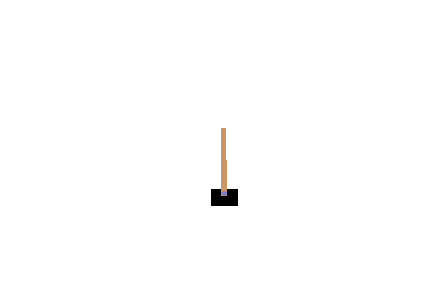
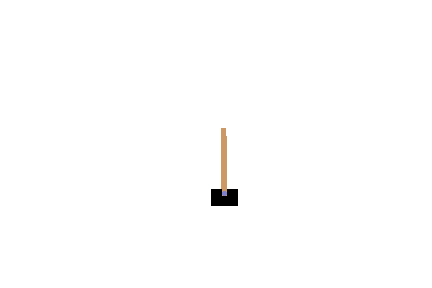
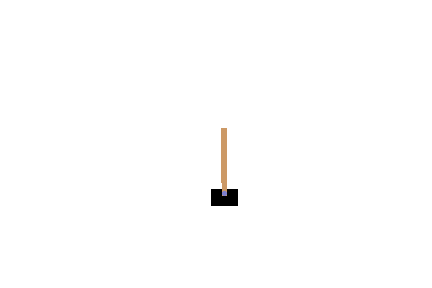
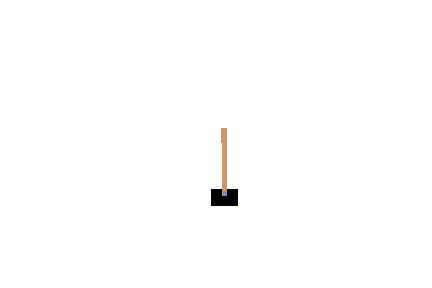
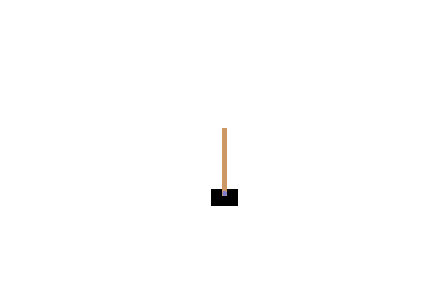
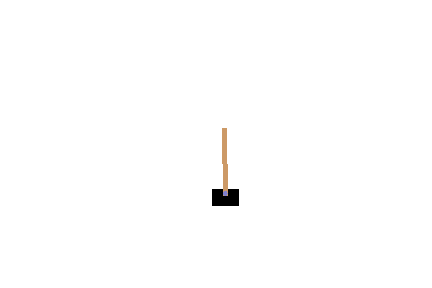
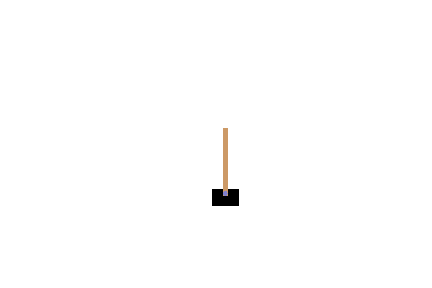
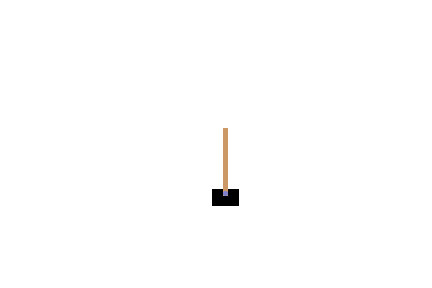
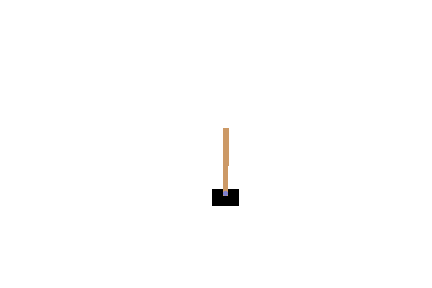
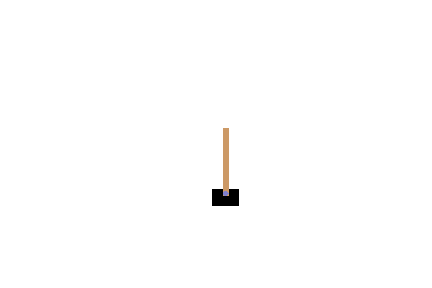
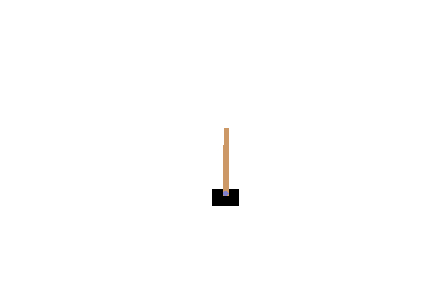
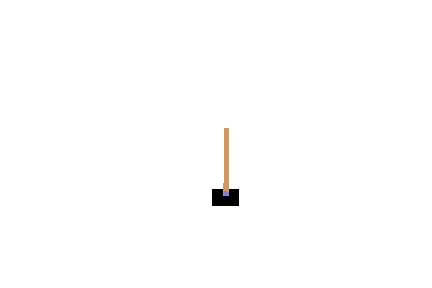
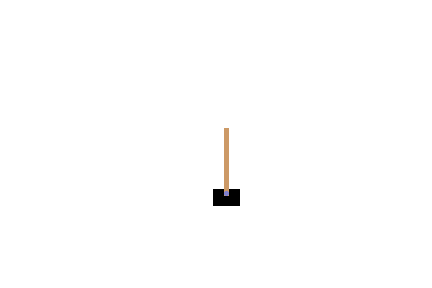
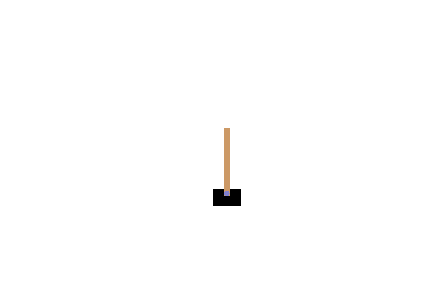
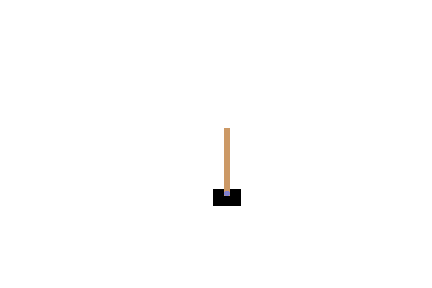
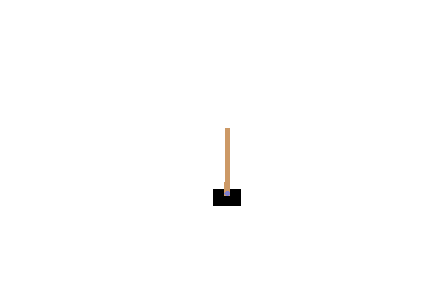
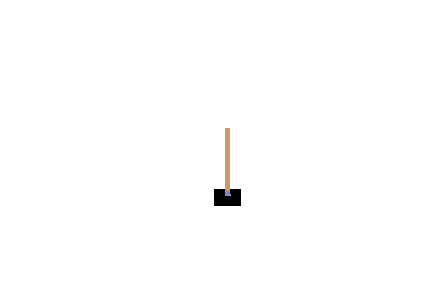
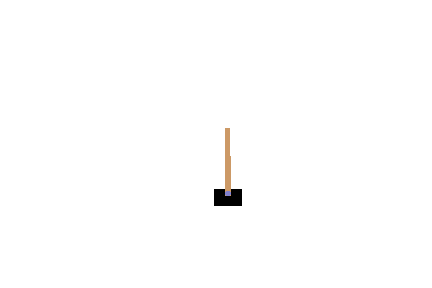
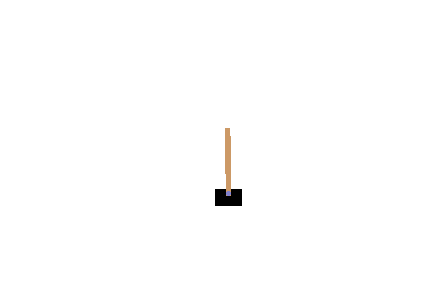
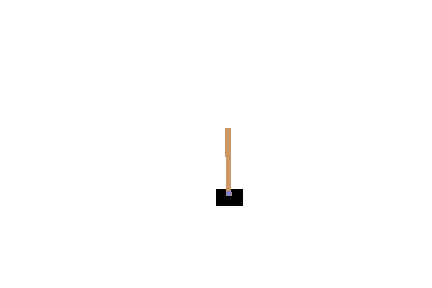
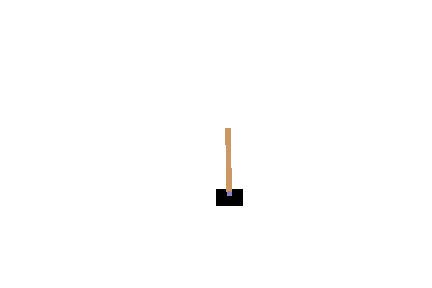
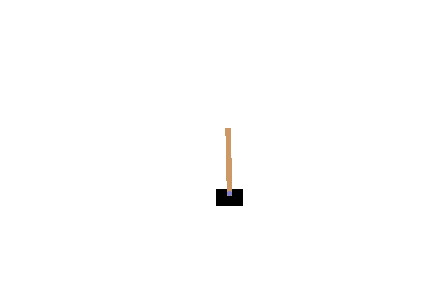
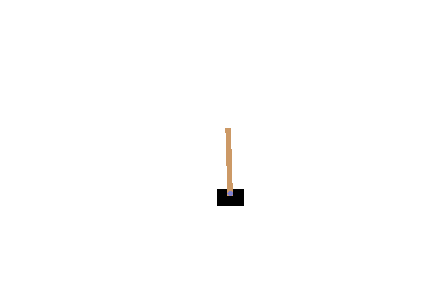
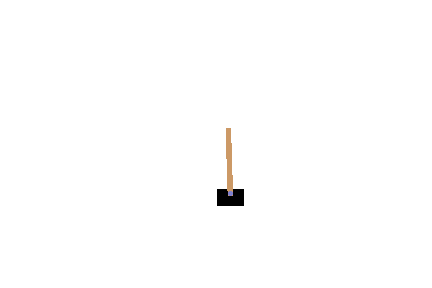
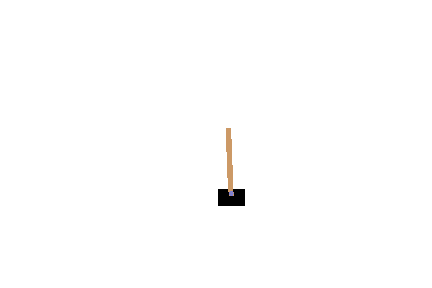
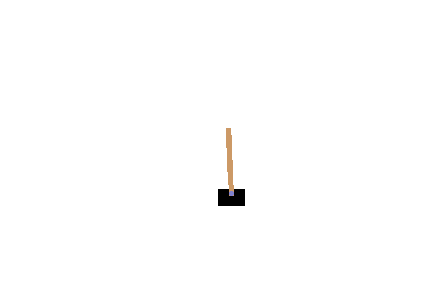
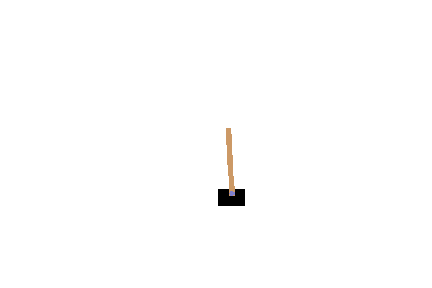
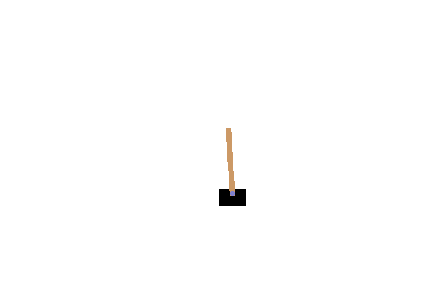
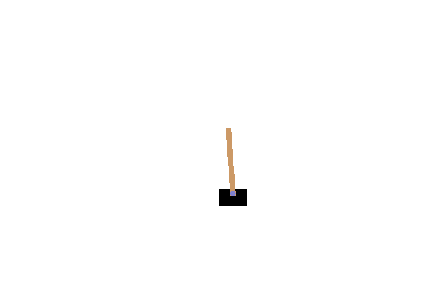
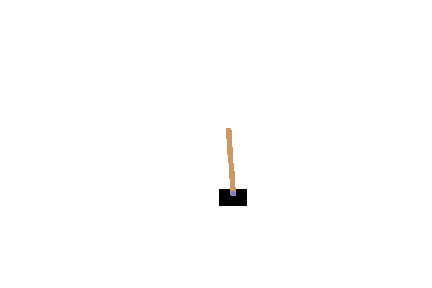
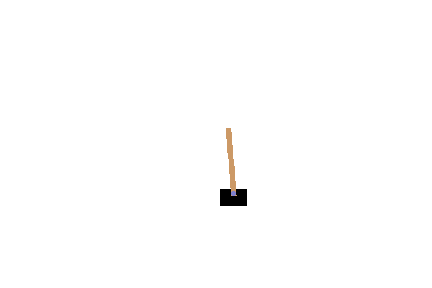
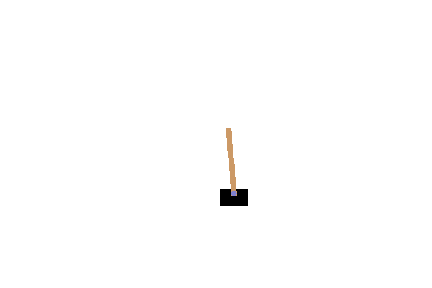
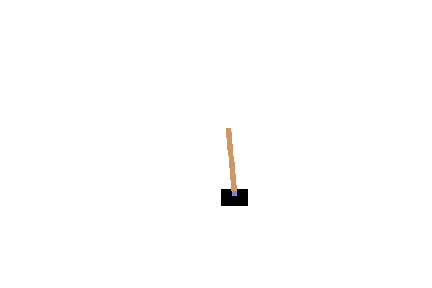
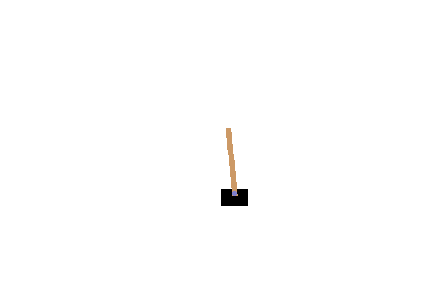
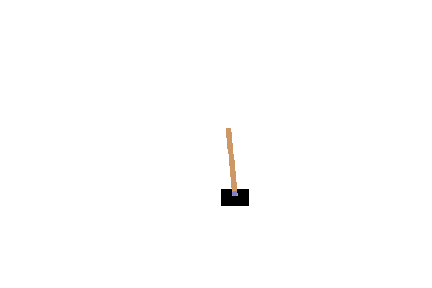
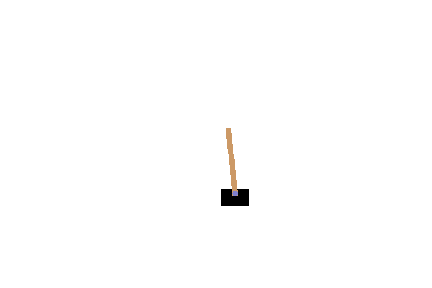
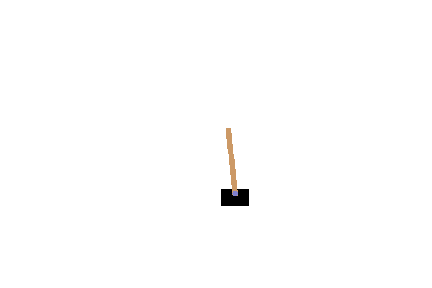
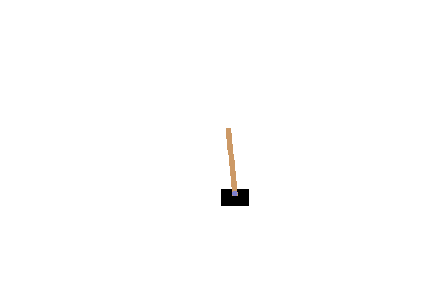
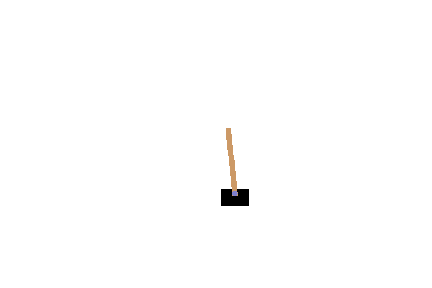
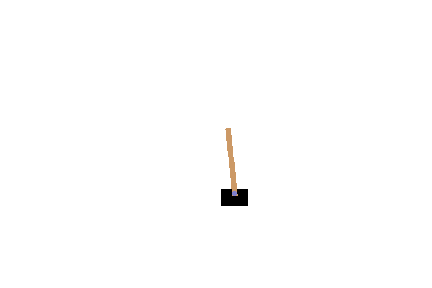
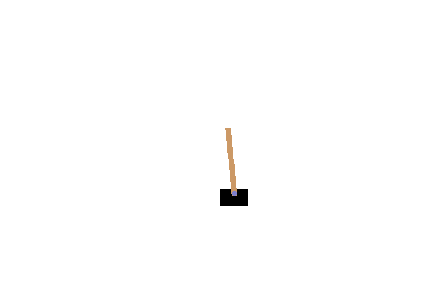
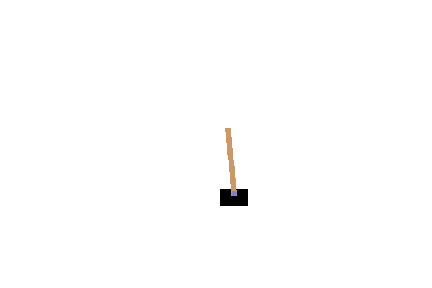
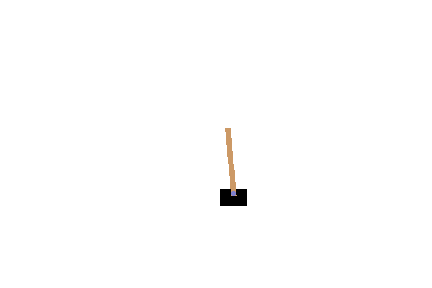
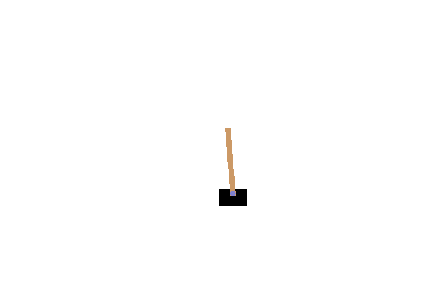
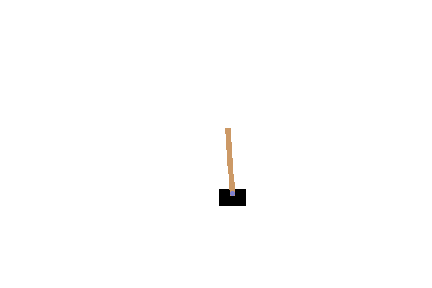
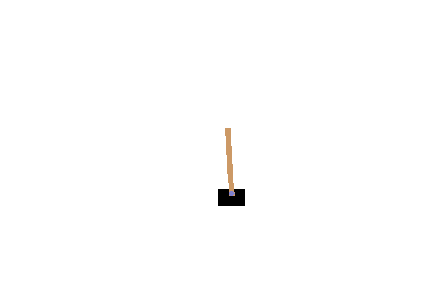
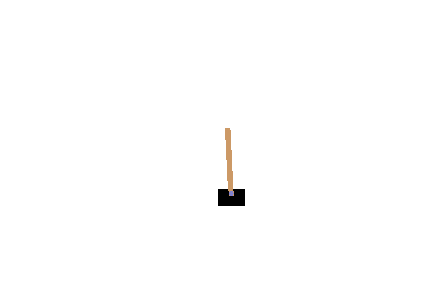
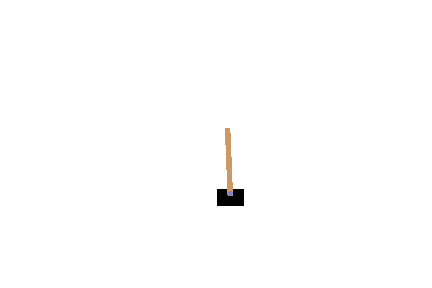
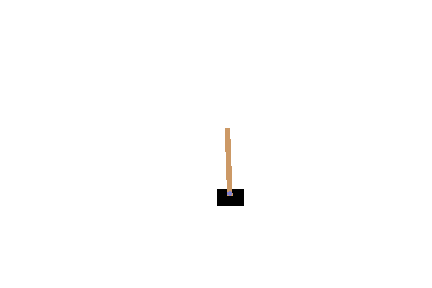
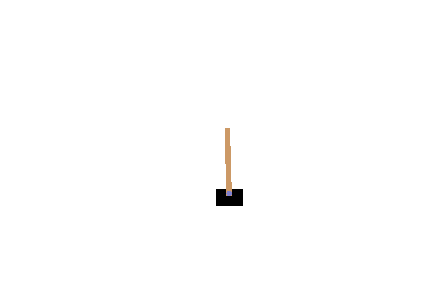
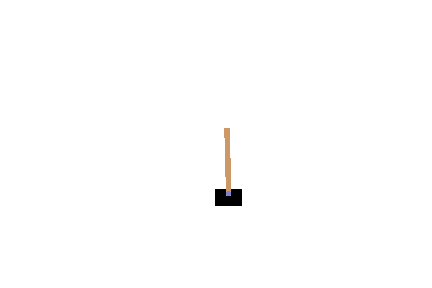
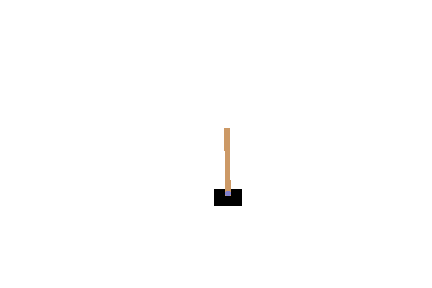
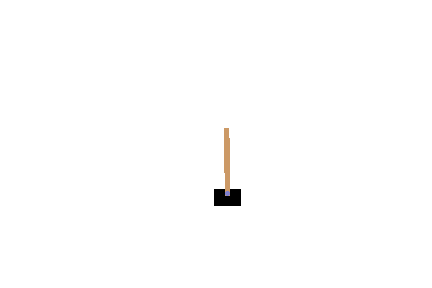
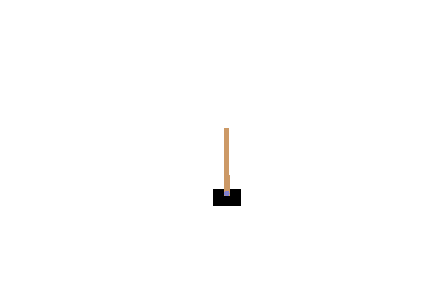
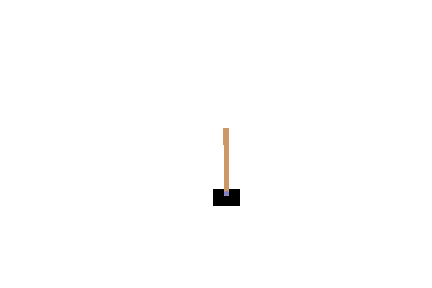
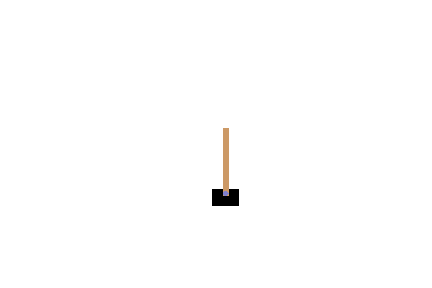
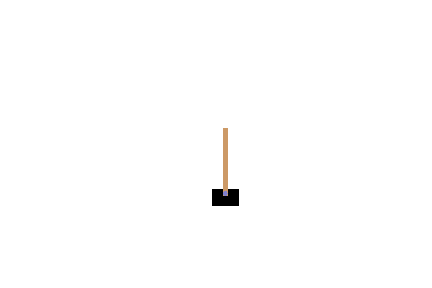
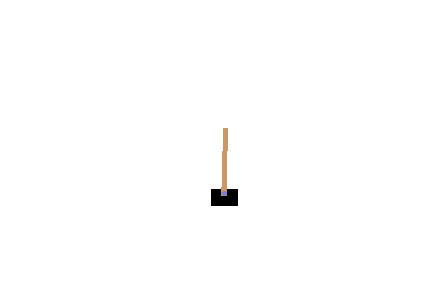
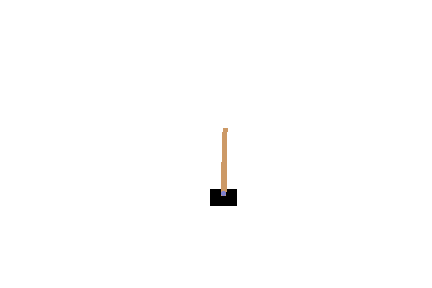
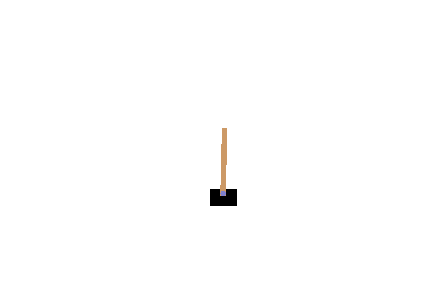
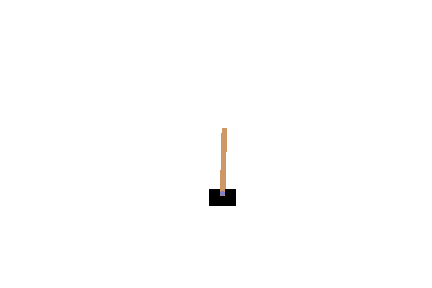
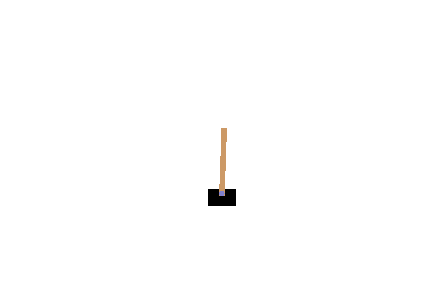
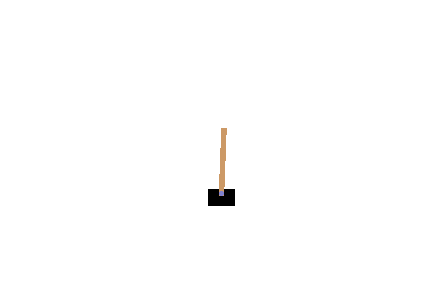
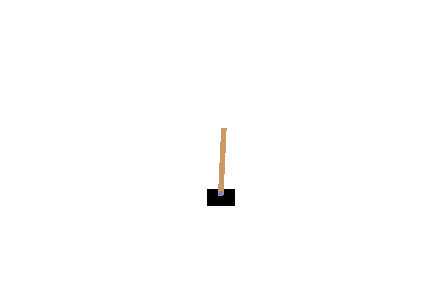
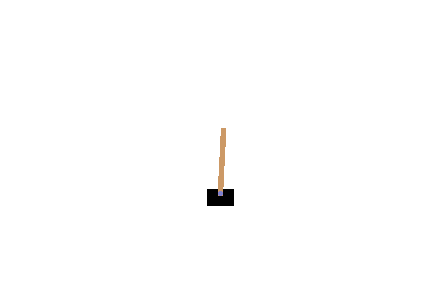
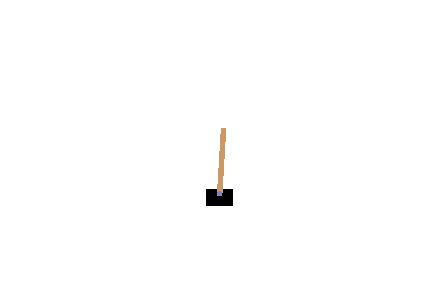
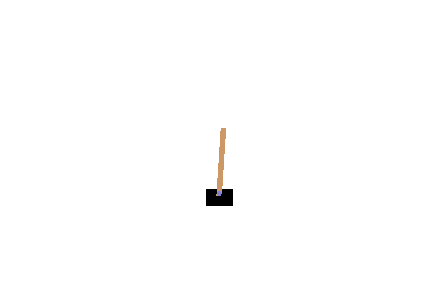
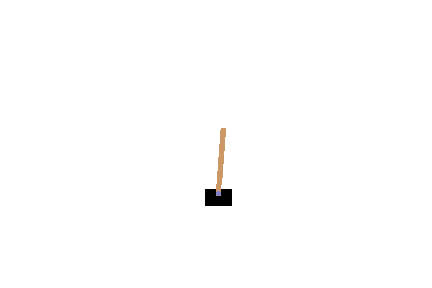
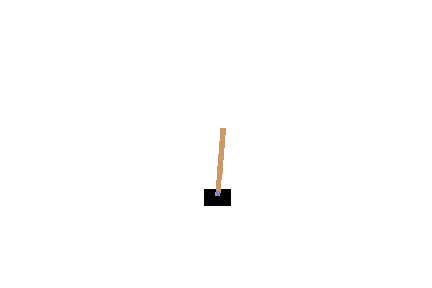
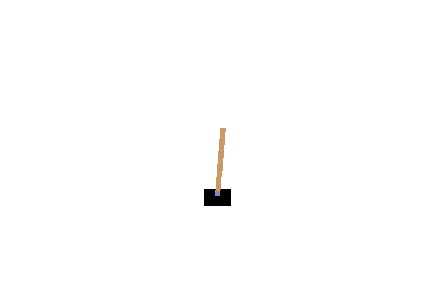
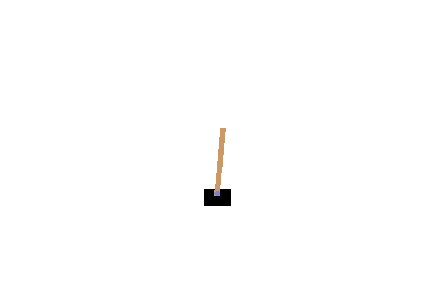
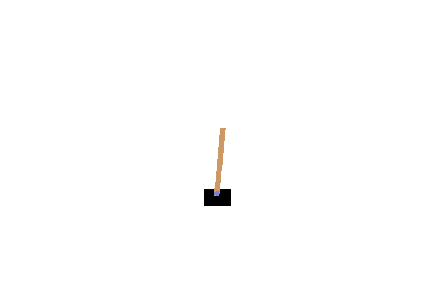
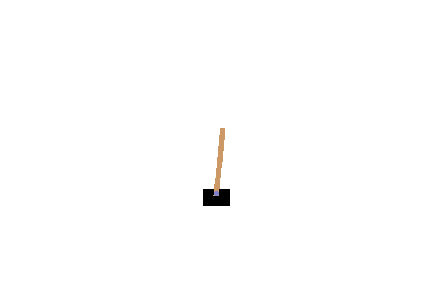
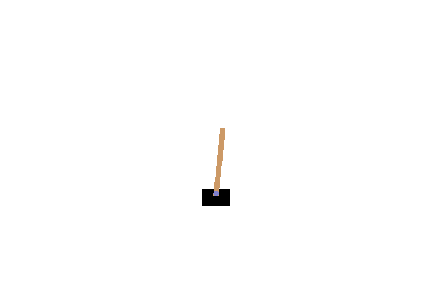
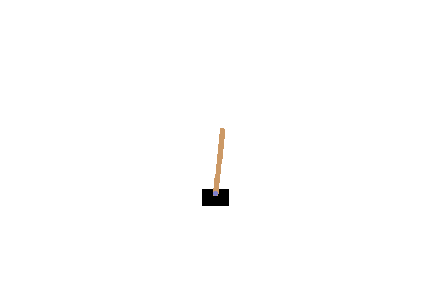
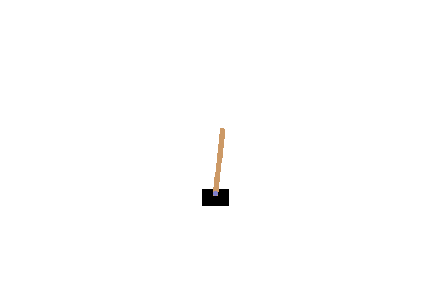
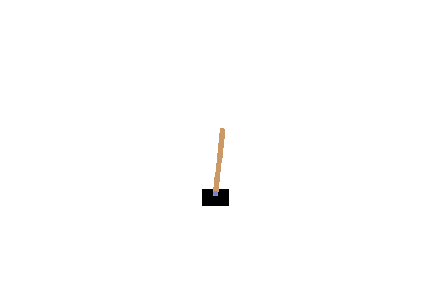
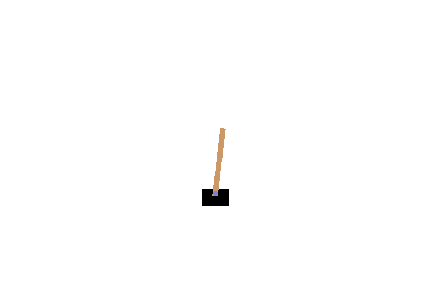
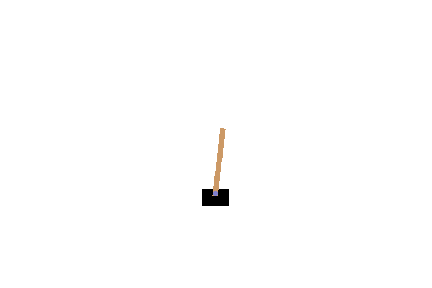
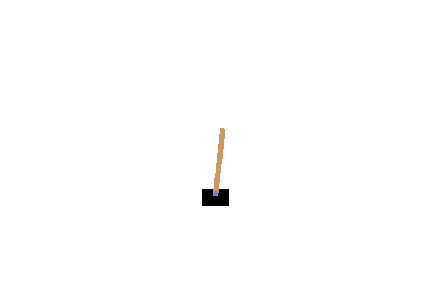
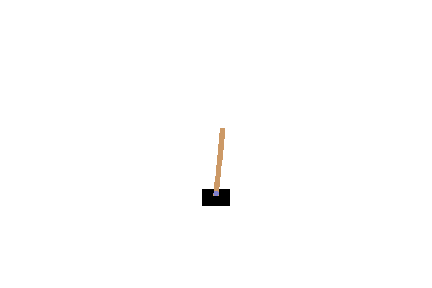
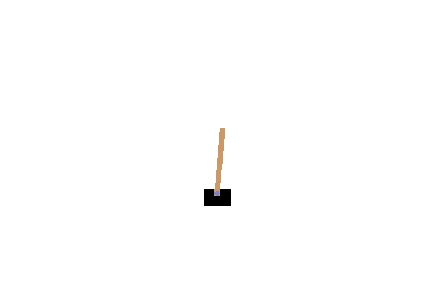
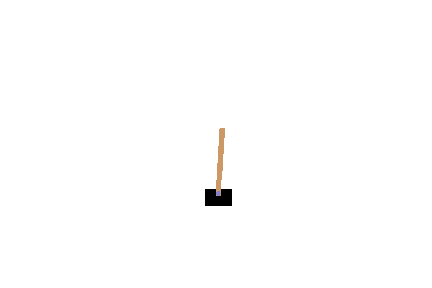
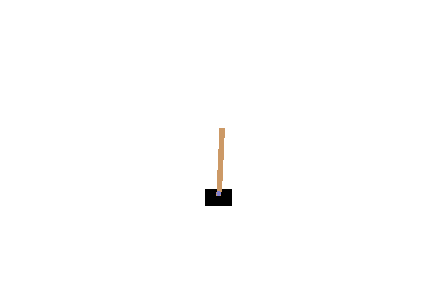
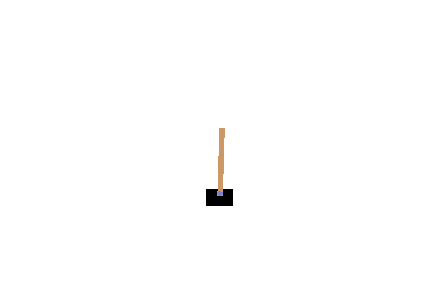
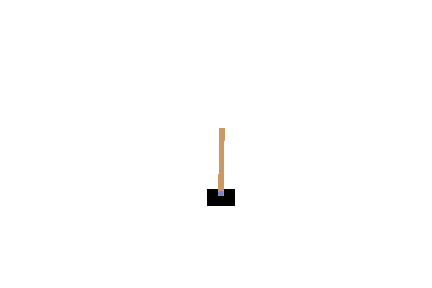
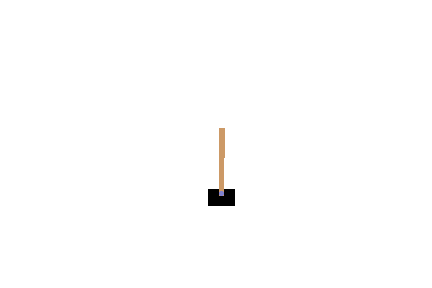
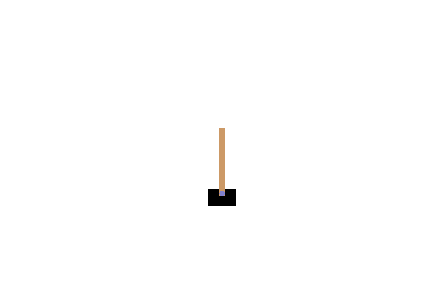
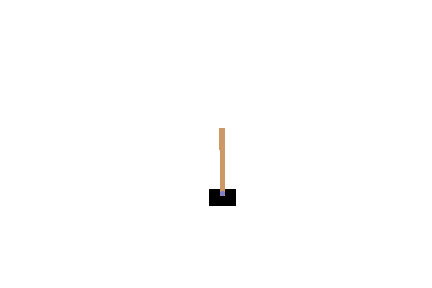
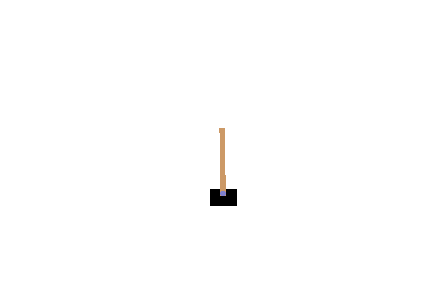
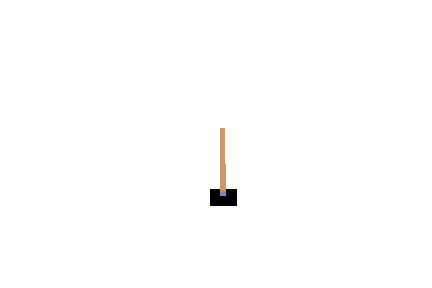
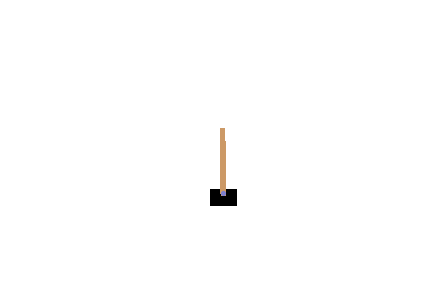
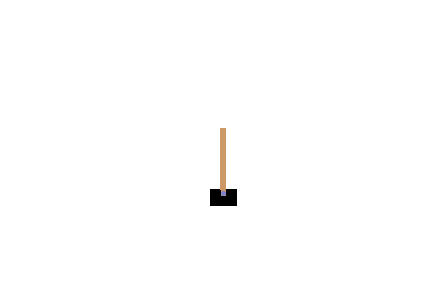
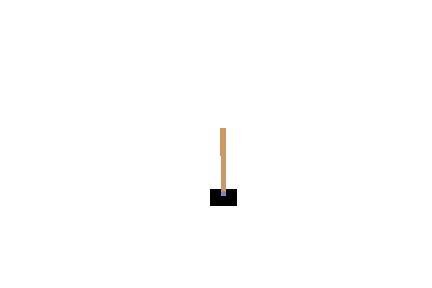
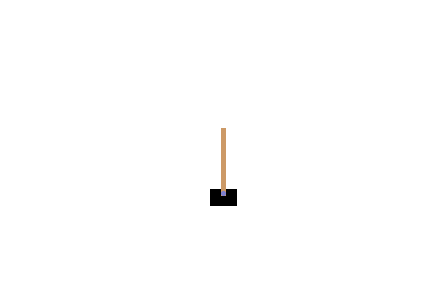
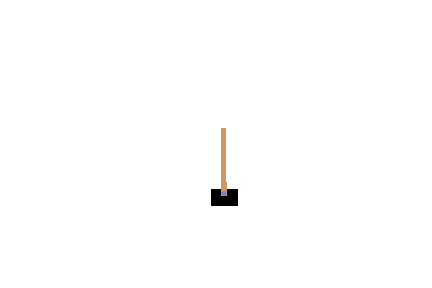
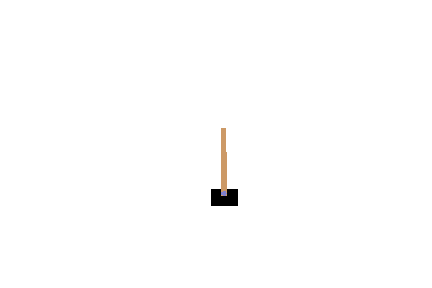
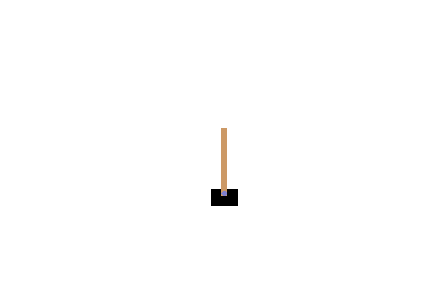
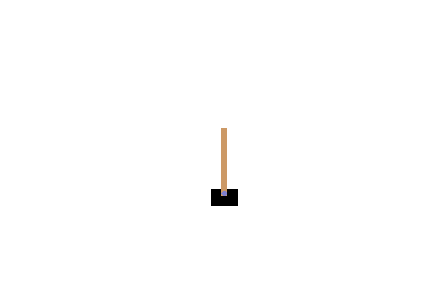
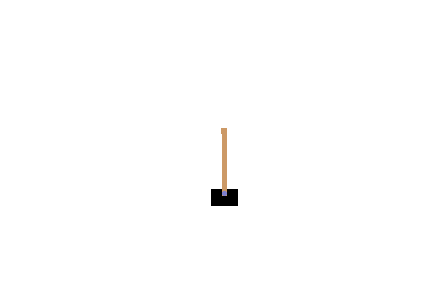
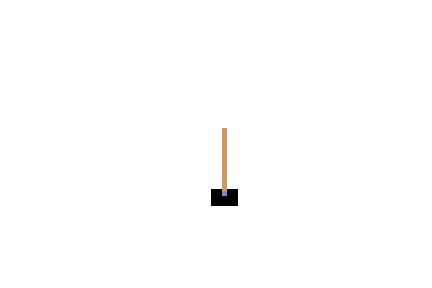
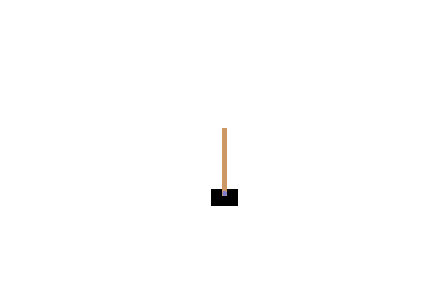
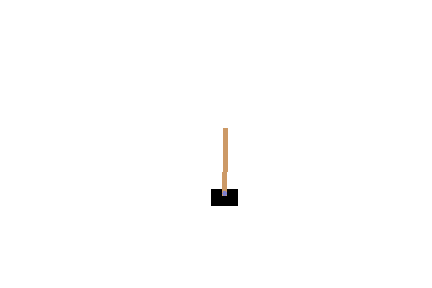
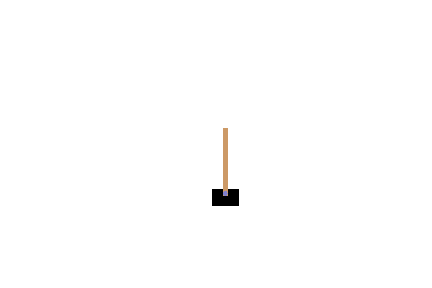
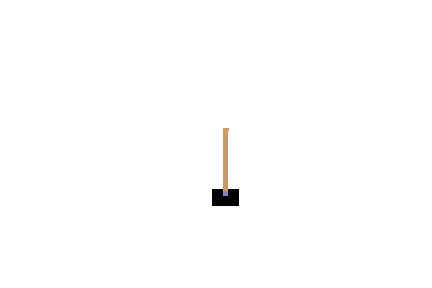
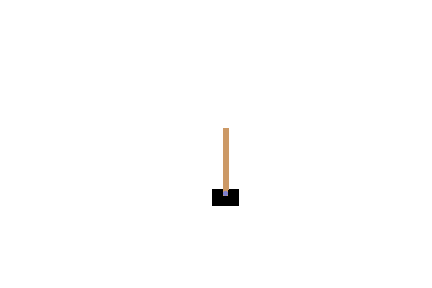
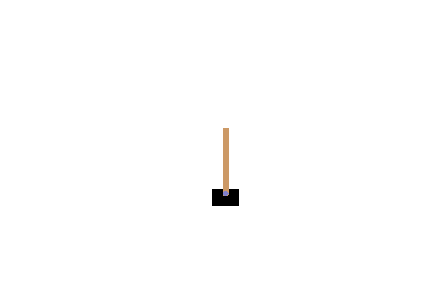
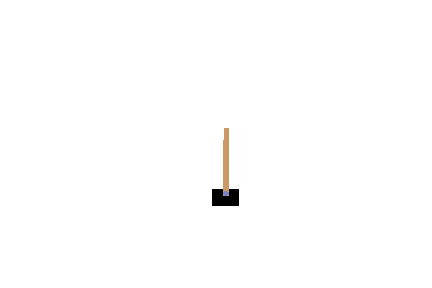
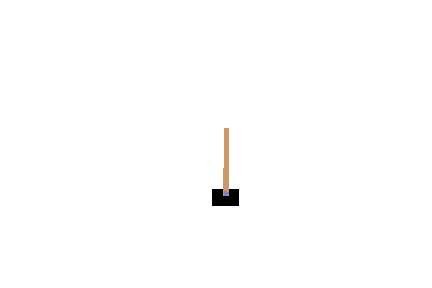
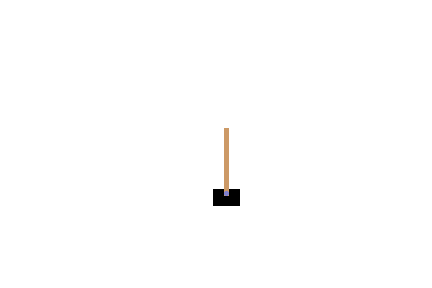
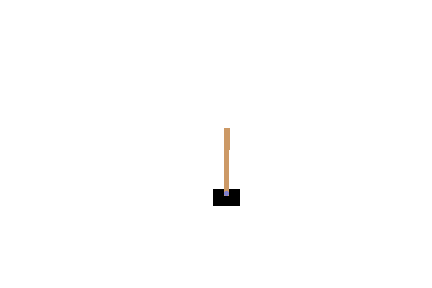
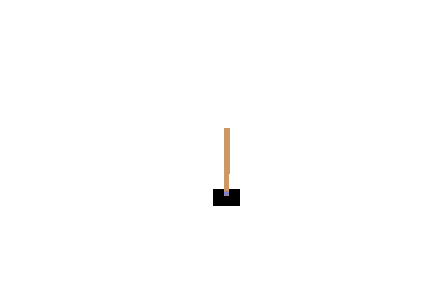
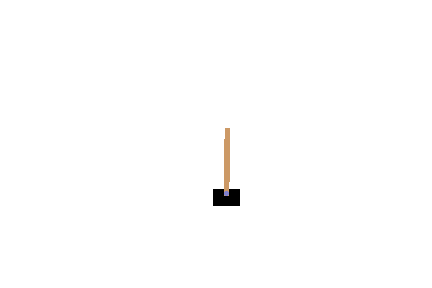
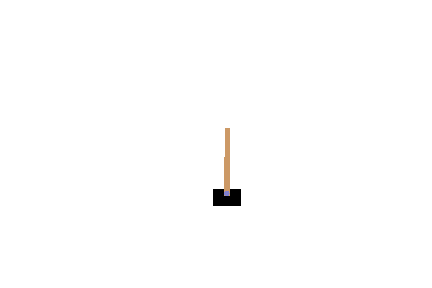
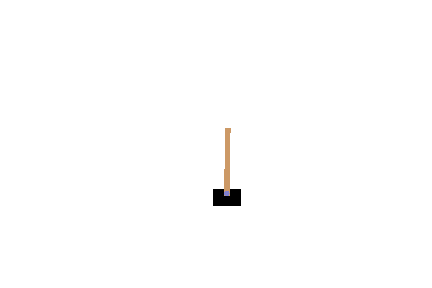
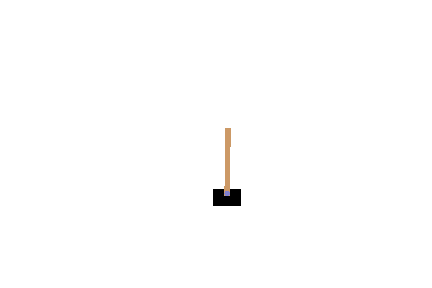
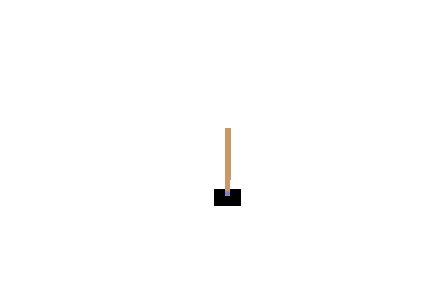
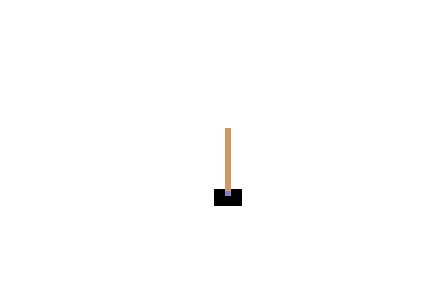
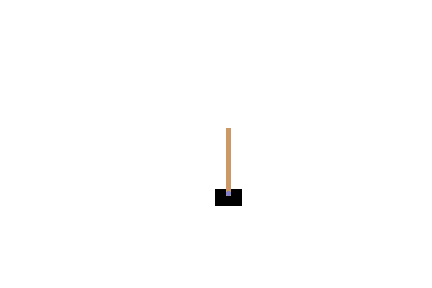
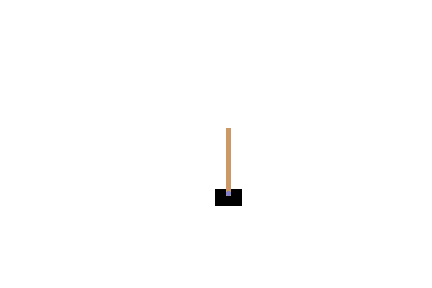
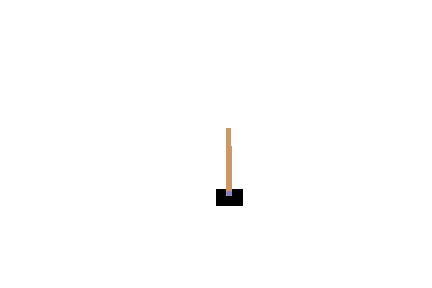
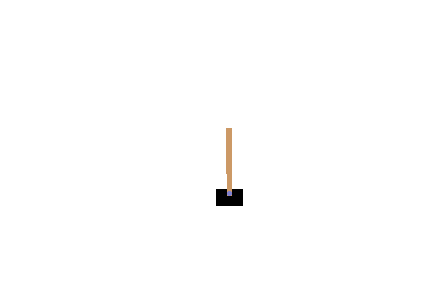
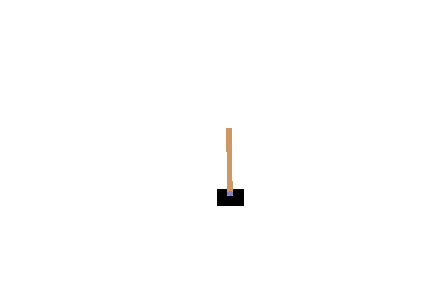
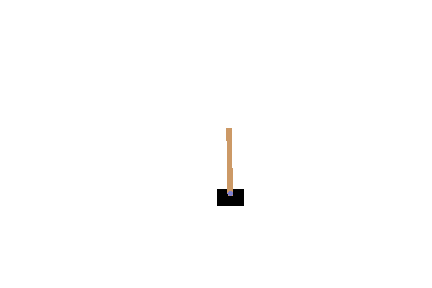
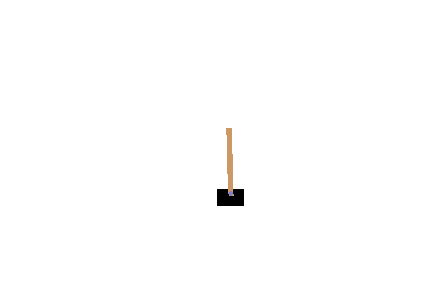
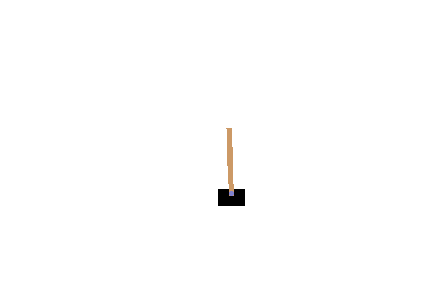
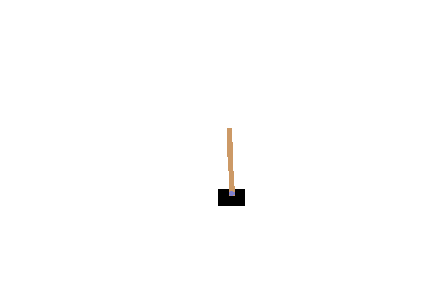
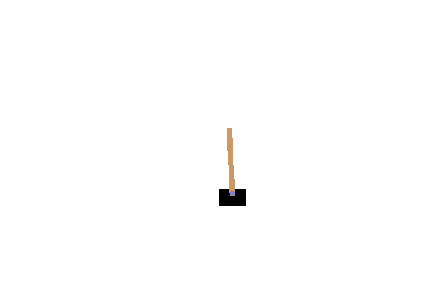
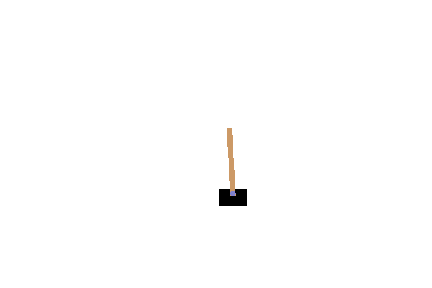
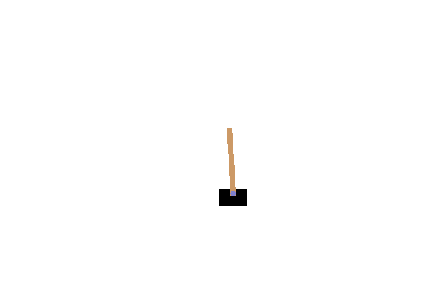
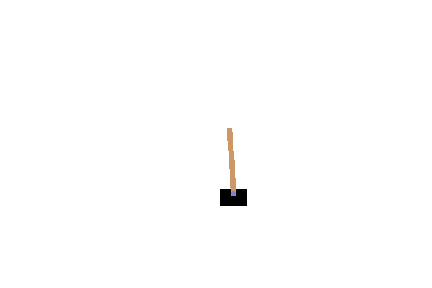
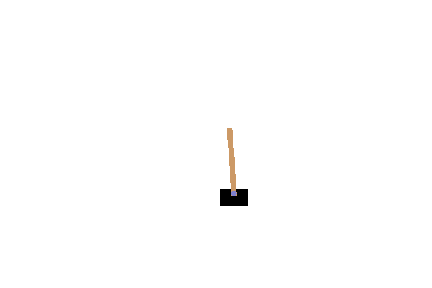
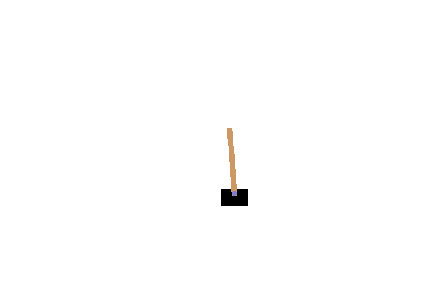
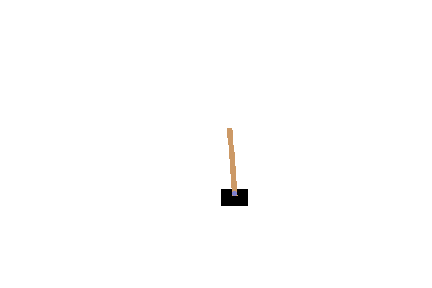
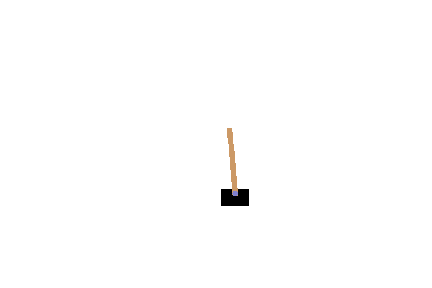
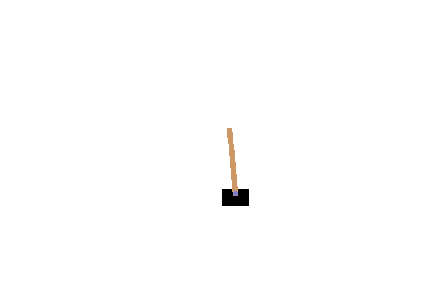
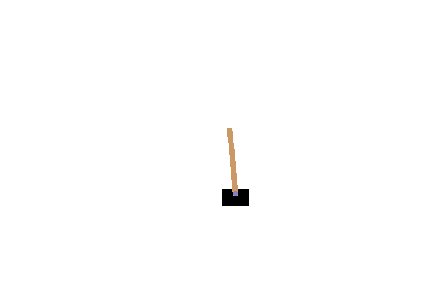
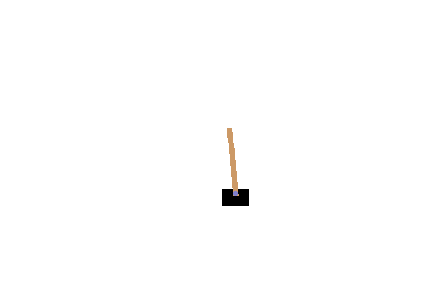
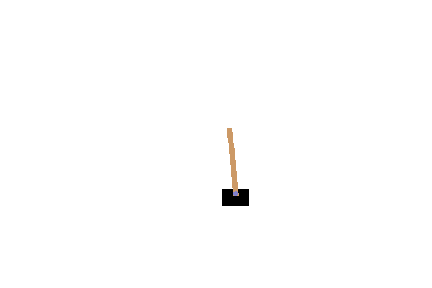
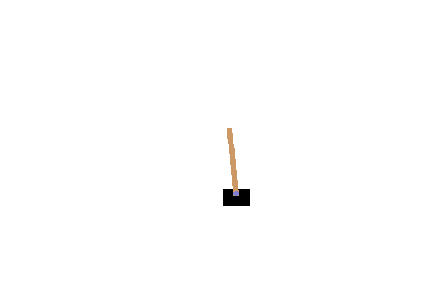
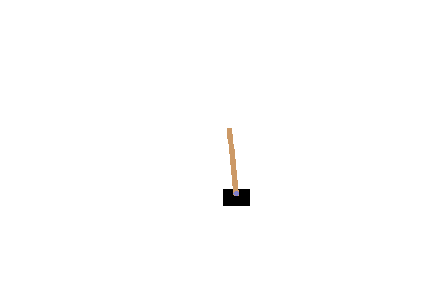
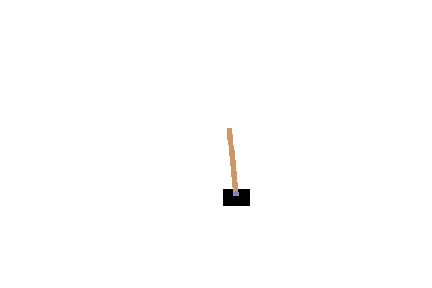
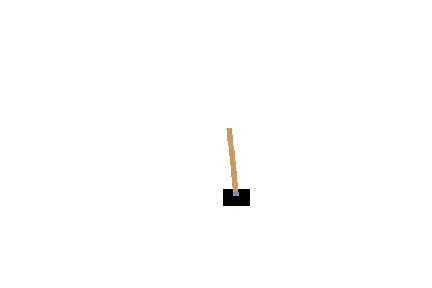
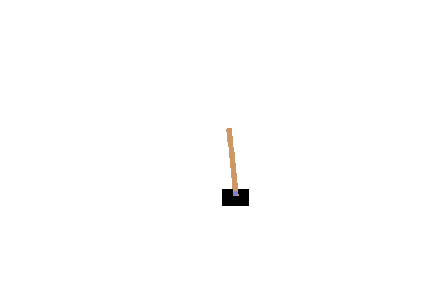
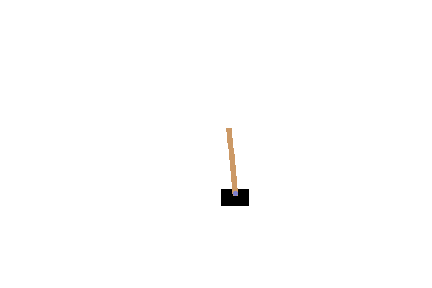
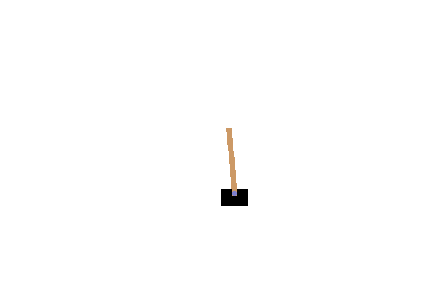
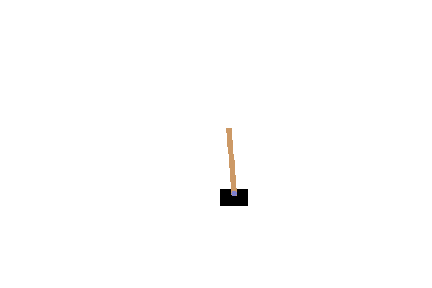
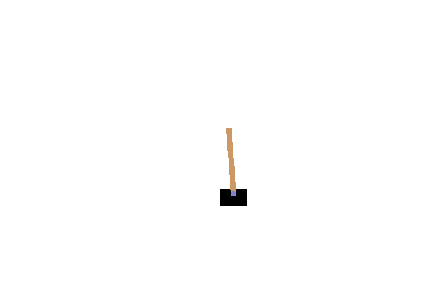
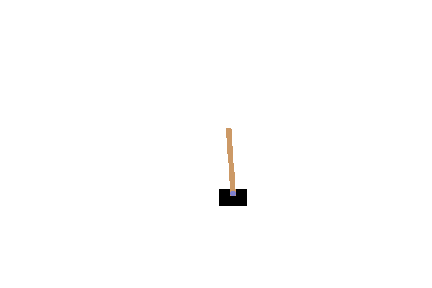
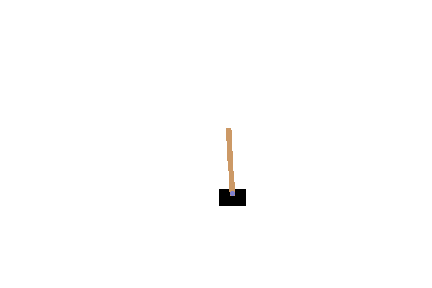
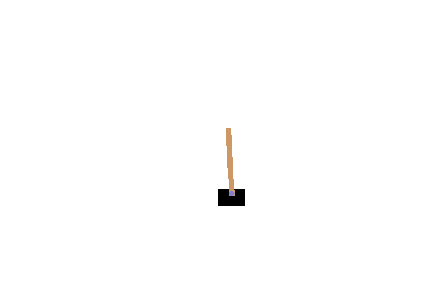
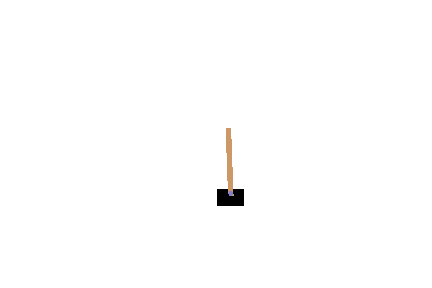
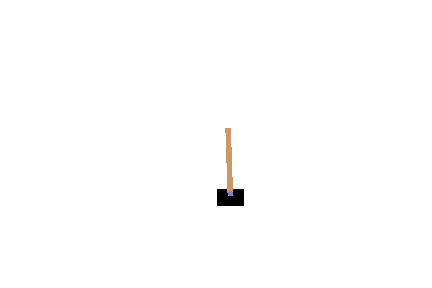
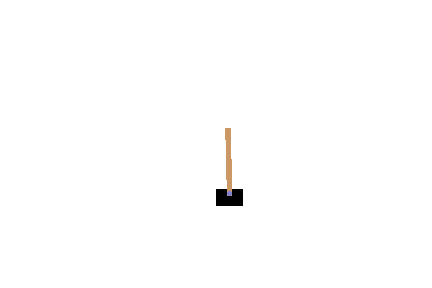
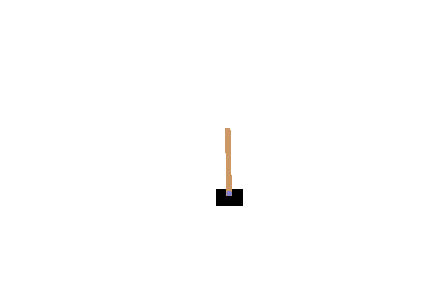
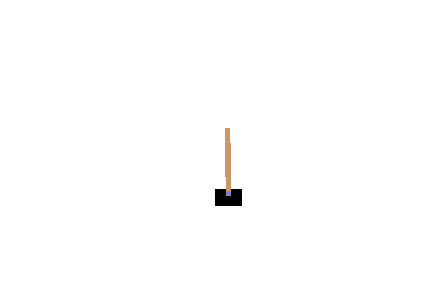
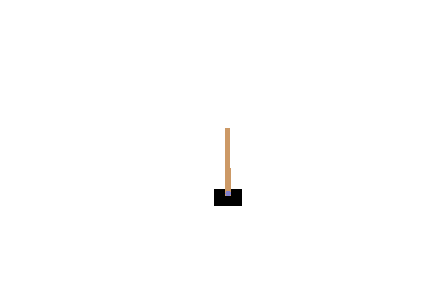
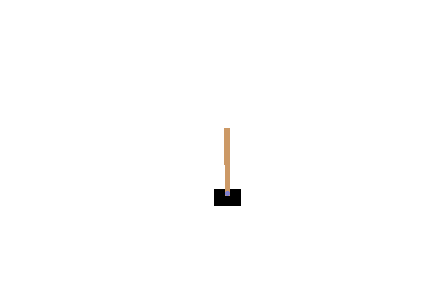
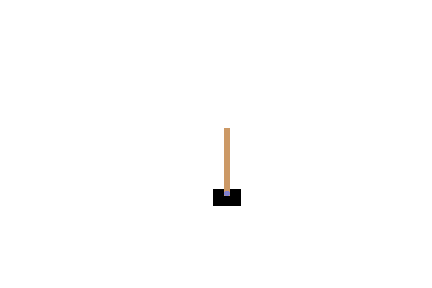
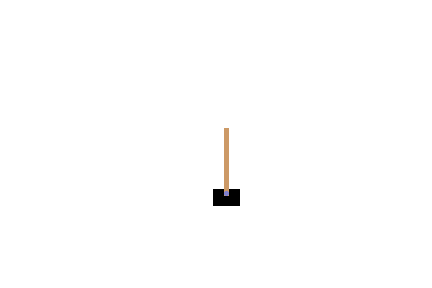
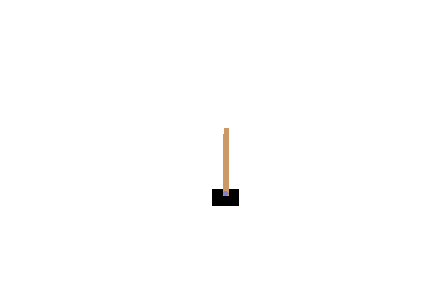
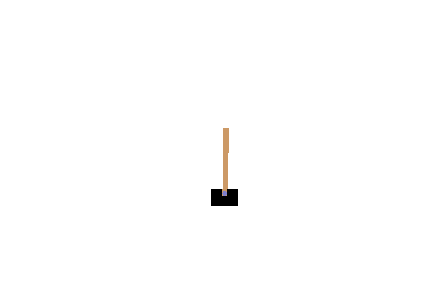
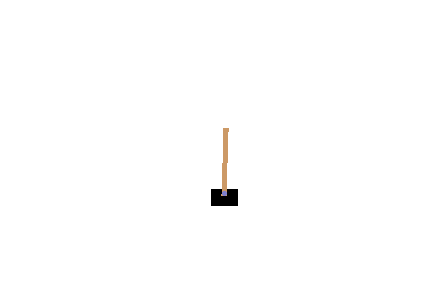
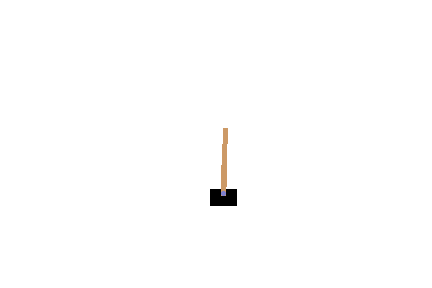
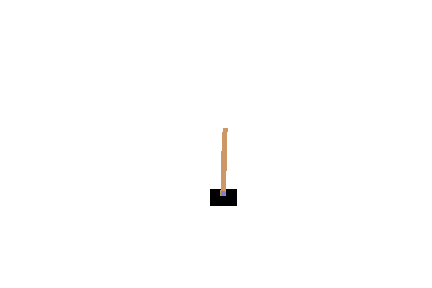
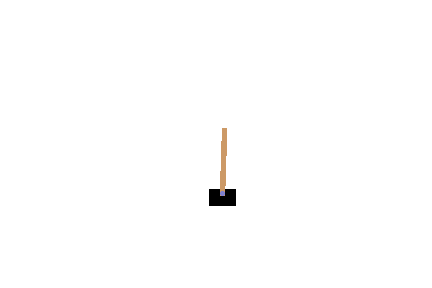
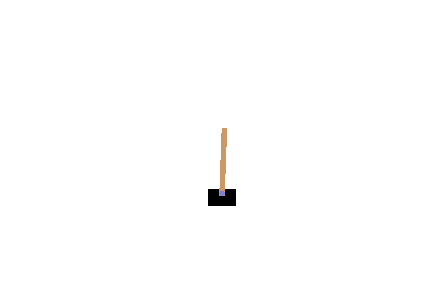
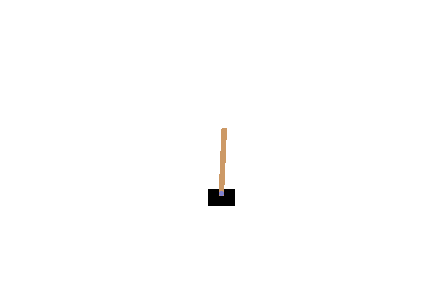
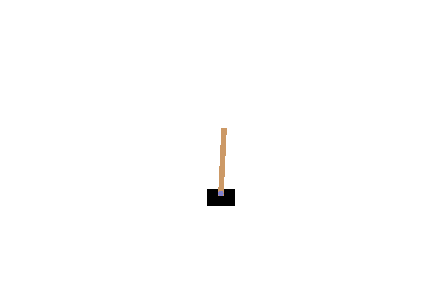
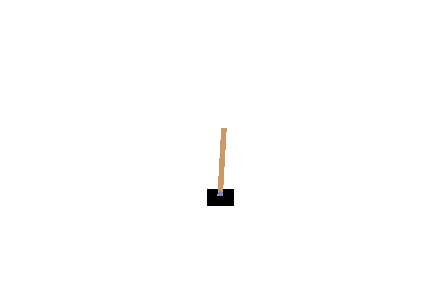
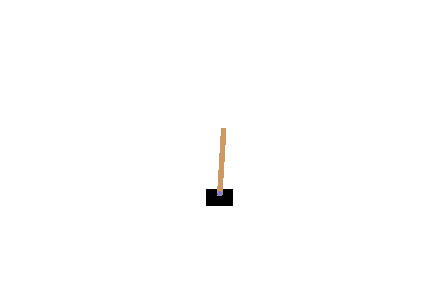
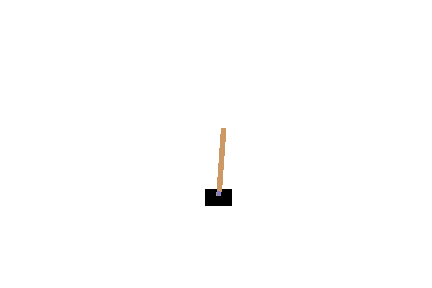
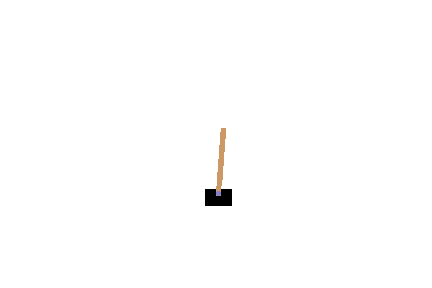
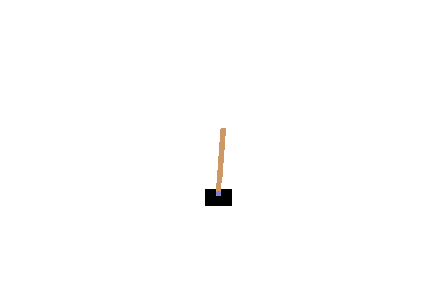
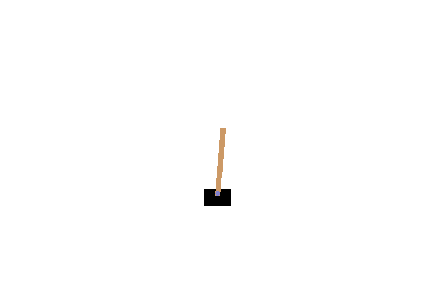

Total reward:  200.0


In [13]:
run_one_episode(q_net, env)